# 1) implementing transreid 

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import cv2
import torch
import numpy as np
from ultralytics import YOLO
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image


### transreid for tacticam

In [2]:
# ----- CONFIG -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLO("model/best.pt")  # Your fine-tuned YOLOv8 pose/detector
transreid_weights_path = "transreid.pth"  # Replace with path to TransReID weights
video_path = "dataset/tacticam.mp4"
output_dir = "saved_transreid_embeddings_tacticam"
max_frames = 5

# ----- Load TransReID model using TorchReID -----
from torchreid import models

transreid = models.build_model(
    name='osnet_ain_x1_0',
    num_classes=1000,
    pretrained=True
).to(device)
transreid.eval()

# ----- Transform for TransReID -----
transform = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ----- Setup -----
cap = cv2.VideoCapture(video_path)
os.makedirs(output_dir, exist_ok=True)
frame_count = 0
font = cv2.FONT_HERSHEY_SIMPLEX

# ----- Main Processing Loop -----
while frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        print("End of video.")
        break

    result = model.predict(source=frame, conf=0.75, save=False, verbose=False)[0]
    annotated = frame.copy()

    frame_dir = os.path.join(output_dir, f"frame_{frame_count}")
    os.makedirs(frame_dir, exist_ok=True)

    boxes = result.boxes
    if boxes is not None:
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cls_id = int(box.cls[0].item())
            class_name = model.names[cls_id]

            if class_name.lower() != "player":
                continue

            crop = frame[y1:y2, x1:x2]
            crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            input_tensor = transform(crop_pil).unsqueeze(0).to(device)

            # ----- TransReID Embedding -----
            emb = transreid(input_tensor)
            emb = F.normalize(emb, p=2, dim=1)  # Optional: normalized embedding

            # Save embedding
            emb_np = emb.detach().cpu().numpy()
            emb_path = os.path.join(frame_dir, f"player_{i}_embedding.npy")
            np.save(emb_path, emb_np)

            # Save crop
            crop_path = os.path.join(frame_dir, f"player_{i}.jpg")
            cv2.imwrite(crop_path, crop)

            # Annotate
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(annotated, f"Player {i}", (x1, y1 - 10), font, 0.6, (0, 255, 0), 2)

    # Save annotated frame
    frame_path = os.path.join(frame_dir, "annotated.jpg")
    cv2.imwrite(frame_path, annotated)

    print(f"[Frame {frame_count}] Processed and saved.")
    frame_count += 1

cap.release()

Successfully loaded imagenet pretrained weights from "/Users/vivek/.cache/torch/checkpoints/osnet_ain_x1_0_imagenet.pth"
[Frame 0] Processed and saved.
[Frame 1] Processed and saved.
[Frame 2] Processed and saved.
[Frame 3] Processed and saved.
[Frame 4] Processed and saved.


### transreid for broadcast

In [3]:
# ----- CONFIG -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLO("model/best.pt")  # Your fine-tuned YOLOv8 pose/detector
transreid_weights_path = "transreid.pth"  # Replace with path to TransReID weights
video_path = "dataset/broadcast.mp4"
output_dir = "saved_transreid_embeddings_broadcast"
max_frames = 5

# ----- Load TransReID model using TorchReID -----
from torchreid import models

transreid = models.build_model(
    name='osnet_ain_x1_0',
    num_classes=1000,
    pretrained=True
).to(device)
transreid.eval()

# ----- Transform for TransReID -----
transform = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ----- Setup -----
cap = cv2.VideoCapture(video_path)
os.makedirs(output_dir, exist_ok=True)
frame_count = 0
font = cv2.FONT_HERSHEY_SIMPLEX

# ----- Main Processing Loop -----
while frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        print("End of video.")
        break

    result = model.predict(source=frame, conf=0.75, save=False, verbose=False)[0]
    annotated = frame.copy()

    frame_dir = os.path.join(output_dir, f"frame_{frame_count}")
    os.makedirs(frame_dir, exist_ok=True)

    boxes = result.boxes
    if boxes is not None:
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cls_id = int(box.cls[0].item())
            class_name = model.names[cls_id]

            if class_name.lower() != "player":
                continue

            crop = frame[y1:y2, x1:x2]
            crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            input_tensor = transform(crop_pil).unsqueeze(0).to(device)

            # ----- TransReID Embedding -----
            emb = transreid(input_tensor)
            emb = F.normalize(emb, p=2, dim=1)  # Optional: normalized embedding

            # Save embedding
            emb_np = emb.detach().cpu().numpy()
            emb_path = os.path.join(frame_dir, f"player_{i}_embedding.npy")
            np.save(emb_path, emb_np)

            # Save crop
            crop_path = os.path.join(frame_dir, f"player_{i}.jpg")
            cv2.imwrite(crop_path, crop)

            # Annotate
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(annotated, f"Player {i}", (x1, y1 - 10), font, 0.6, (0, 255, 0), 2)

    # Save annotated frame
    frame_path = os.path.join(frame_dir, "annotated.jpg")
    cv2.imwrite(frame_path, annotated)

    print(f"[Frame {frame_count}] Processed and saved.")
    frame_count += 1

cap.release()

Successfully loaded imagenet pretrained weights from "/Users/vivek/.cache/torch/checkpoints/osnet_ain_x1_0_imagenet.pth"
[Frame 0] Processed and saved.
[Frame 1] Processed and saved.
[Frame 2] Processed and saved.
[Frame 3] Processed and saved.
[Frame 4] Processed and saved.


### getting the similarity score for two frames, one from tacticama nd one from broadcast

In [7]:
import os
import numpy as np
import torch
import torch.nn.functional as F

# ----------- Set your input directories here -----------
frame_dir_1 = "saved_transreid_embeddings_tacticam/frame_0"
frame_dir_2 = "saved_transreid_embeddings_broadcast/frame_0"
# --------------------------------------------------------

def load_embeddings_from_dir(frame_dir):
    embeddings = []
    names = []

    for file in os.listdir(frame_dir):
        if file.endswith("_embedding.npy"):
            path = os.path.join(frame_dir, file)
            emb = np.load(path)
            emb = torch.from_numpy(emb).float()
            emb = F.normalize(emb, p=2, dim=1)
            embeddings.append(emb)
            names.append(file.replace("_embedding.npy", ""))
    return embeddings, names

# Load all embeddings
emb_list_1, names_1 = load_embeddings_from_dir(frame_dir_1)
emb_list_2, names_2 = load_embeddings_from_dir(frame_dir_2)

# Compute pairwise cosine similarities
print(f"\n🔍 Similarity Matrix (Players in Frame 1 vs Frame 2):\n")
for i, (emb1, name1) in enumerate(zip(emb_list_1, names_1)):
    row = []
    for j, (emb2, name2) in enumerate(zip(emb_list_2, names_2)):
        sim = torch.mm(emb1, emb2.t()).item()
        row.append(f"{sim:.3f}")
    print(f"{name1:20}: {'  '.join(row)}")


🔍 Similarity Matrix (Players in Frame 1 vs Frame 2):

player_4            : 0.575  0.684  0.590  0.699  0.608  0.574  0.599  0.645  0.683  0.629  0.500
player_0            : 0.531  0.734  0.641  0.593  0.608  0.604  0.513  0.649  0.541  0.611  0.521
player_21           : 0.626  0.601  0.580  0.590  0.663  0.631  0.666  0.701  0.513  0.563  0.538
player_18           : 0.542  0.673  0.638  0.646  0.661  0.594  0.578  0.683  0.579  0.603  0.492
player_7            : 0.583  0.588  0.555  0.539  0.683  0.633  0.631  0.752  0.512  0.500  0.494
player_3            : 0.575  0.612  0.627  0.537  0.649  0.635  0.590  0.688  0.451  0.578  0.476
player_9            : 0.594  0.659  0.628  0.579  0.682  0.600  0.585  0.704  0.514  0.618  0.507
player_12           : 0.605  0.581  0.513  0.561  0.630  0.634  0.606  0.731  0.491  0.511  0.455
player_16           : 0.580  0.584  0.603  0.541  0.704  0.626  0.642  0.709  0.492  0.579  0.578
player_11           : 0.468  0.593  0.579  0.530  0.601  0.513 

## plot confustion matrix

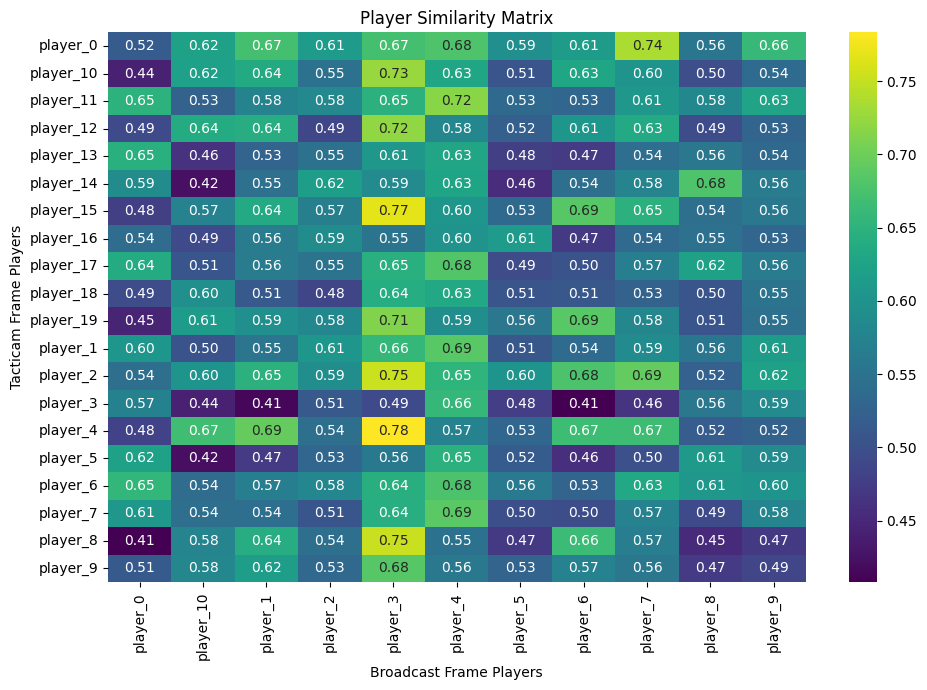

In [10]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# ----------- Set your input directories here -----------
frame_dir_1 = "saved_transreid_embeddings_tacticam/frame_4"
frame_dir_2 = "saved_transreid_embeddings_broadcast/frame_4"
# --------------------------------------------------------

def load_embeddings_from_dir(frame_dir):
    embeddings = []
    names = []

    for file in sorted(os.listdir(frame_dir)):
        if file.endswith("_embedding.npy"):
            path = os.path.join(frame_dir, file)
            emb = np.load(path)
            emb = torch.from_numpy(emb).float()
            emb = F.normalize(emb, p=2, dim=1)
            embeddings.append(emb)
            names.append(file.replace("_embedding.npy", ""))
    return embeddings, names

# Load embeddings
emb_list_1, names_1 = load_embeddings_from_dir(frame_dir_1)
emb_list_2, names_2 = load_embeddings_from_dir(frame_dir_2)

# Compute similarity matrix
similarity_matrix = np.zeros((len(emb_list_1), len(emb_list_2)))

for i, emb1 in enumerate(emb_list_1):
    for j, emb2 in enumerate(emb_list_2):
        sim = torch.mm(emb1, emb2.t()).item()
        similarity_matrix[i, j] = sim

# ---- Plot using seaborn ----
plt.figure(figsize=(10, 7))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="viridis", xticklabels=names_2, yticklabels=names_1)
plt.xlabel("Broadcast Frame Players")
plt.ylabel("Tacticam Frame Players")
plt.title("Player Similarity Matrix")
plt.tight_layout()
plt.show()

# 2) implementing LBP and color histogram

In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import cv2
import numpy as np
from ultralytics import YOLO
from skimage.feature import local_binary_pattern

# ----- CONFIG -----
video_path = "dataset/tacticam.mp4"
output_dir = "saved_LBP_tacticam"
model = YOLO("model/best.pt")
max_frames = 5

cap = cv2.VideoCapture(video_path)
os.makedirs(output_dir, exist_ok=True)
frame_count = 0
font = cv2.FONT_HERSHEY_SIMPLEX

# LBP parameters
radius = 2
n_points = 8 * radius
METHOD = 'uniform'

while frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        print("End of video.")
        break

    result = model.predict(source=frame, conf=0.75, save=False, verbose=False)[0]
    annotated = frame.copy()
    frame_dir = os.path.join(output_dir, f"frame_{frame_count}")
    os.makedirs(frame_dir, exist_ok=True)

    boxes = result.boxes
    if boxes is not None:
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cls_id = int(box.cls[0].item())
            class_name = model.names[cls_id]

            if class_name.lower() != "player":
                continue

            crop = frame[y1:y2, x1:x2]
            gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            lbp = local_binary_pattern(gray_crop, n_points, radius, METHOD)
            # Histogram of LBP
            (hist, _) = np.histogram(lbp.ravel(),
                                     bins=np.arange(0, n_points + 3),
                                     range=(0, n_points + 2))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-7)

            # Save LBP histogram
            lbp_path = os.path.join(frame_dir, f"player_{i}_lbp.npy")
            np.save(lbp_path, hist)

            # Save crop
            crop_path = os.path.join(frame_dir, f"player_{i}.jpg")
            cv2.imwrite(crop_path, crop)

            # Annotate
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(annotated, f"Player {i}", (x1, y1 - 10), font, 0.6, (255, 0, 0), 2)

    # Save annotated frame
    frame_path = os.path.join(frame_dir, "annotated.jpg")
    cv2.imwrite(frame_path, annotated)

    print(f"[Frame {frame_count}] LBP Processed and saved.")
    frame_count += 1

cap.release()

[Frame 0] LBP Processed and saved.
[Frame 1] LBP Processed and saved.
[Frame 2] LBP Processed and saved.
[Frame 3] LBP Processed and saved.
[Frame 4] LBP Processed and saved.


In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import cv2
import numpy as np
from ultralytics import YOLO
from skimage.feature import local_binary_pattern

# ----- CONFIG -----
video_path = "dataset/broadcast.mp4"
output_dir = "saved_LBP_broadcast"
model = YOLO("model/best.pt")
max_frames = 5

cap = cv2.VideoCapture(video_path)
os.makedirs(output_dir, exist_ok=True)
frame_count = 0
font = cv2.FONT_HERSHEY_SIMPLEX

# LBP parameters
radius = 2
n_points = 8 * radius
METHOD = 'uniform'

while frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        print("End of video.")
        break

    result = model.predict(source=frame, conf=0.75, save=False, verbose=False)[0]
    annotated = frame.copy()
    frame_dir = os.path.join(output_dir, f"frame_{frame_count}")
    os.makedirs(frame_dir, exist_ok=True)

    boxes = result.boxes
    if boxes is not None:
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cls_id = int(box.cls[0].item())
            class_name = model.names[cls_id]

            if class_name.lower() != "player":
                continue

            crop = frame[y1:y2, x1:x2]
            gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            lbp = local_binary_pattern(gray_crop, n_points, radius, METHOD)
            # Histogram of LBP
            (hist, _) = np.histogram(lbp.ravel(),
                                     bins=np.arange(0, n_points + 3),
                                     range=(0, n_points + 2))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-7)

            # Save LBP histogram
            lbp_path = os.path.join(frame_dir, f"player_{i}_lbp.npy")
            np.save(lbp_path, hist)

            # Save crop
            crop_path = os.path.join(frame_dir, f"player_{i}.jpg")
            cv2.imwrite(crop_path, crop)

            # Annotate
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(annotated, f"Player {i}", (x1, y1 - 10), font, 0.6, (255, 0, 0), 2)

    # Save annotated frame
    frame_path = os.path.join(frame_dir, "annotated.jpg")
    cv2.imwrite(frame_path, annotated)

    print(f"[Frame {frame_count}] LBP Processed and saved.")
    frame_count += 1

cap.release()

[Frame 0] LBP Processed and saved.
[Frame 1] LBP Processed and saved.
[Frame 2] LBP Processed and saved.
[Frame 3] LBP Processed and saved.
[Frame 4] LBP Processed and saved.


### ploting histograms

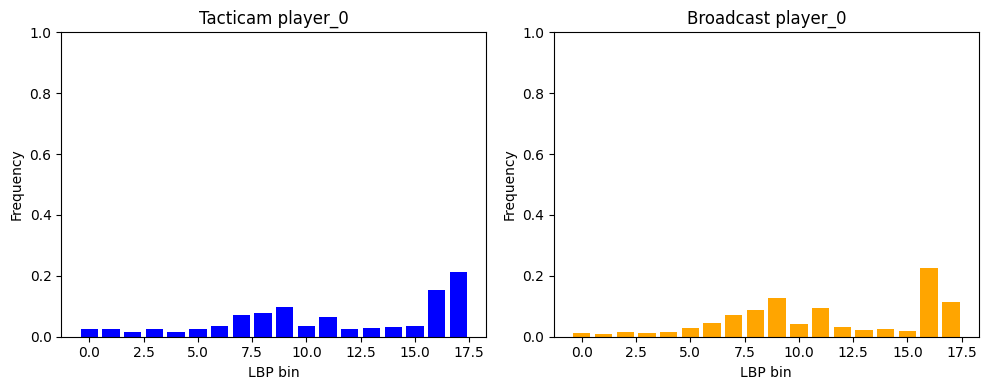

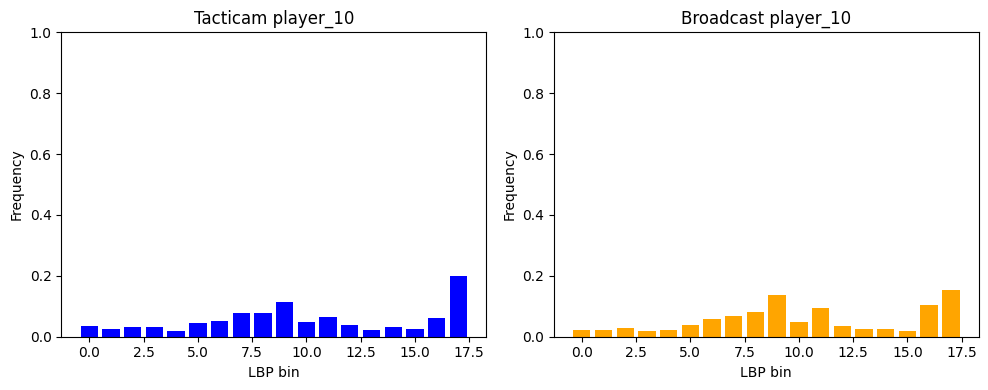

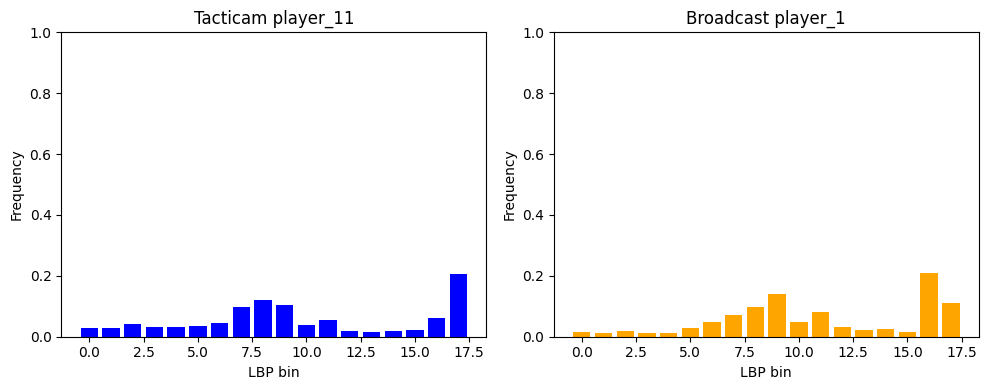

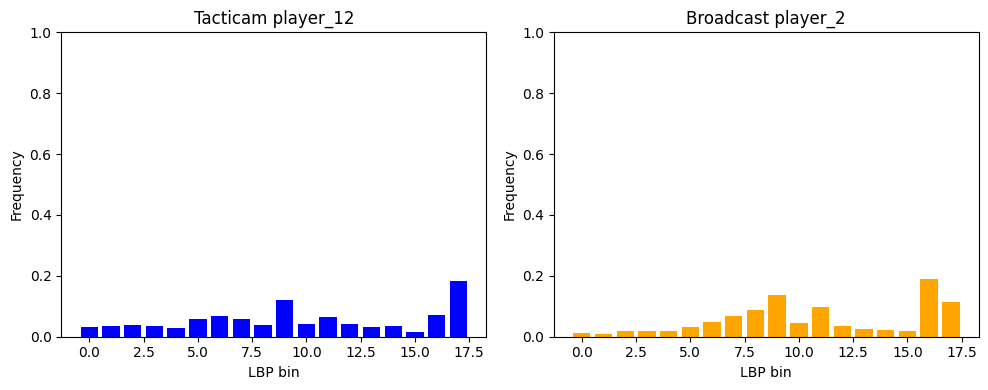

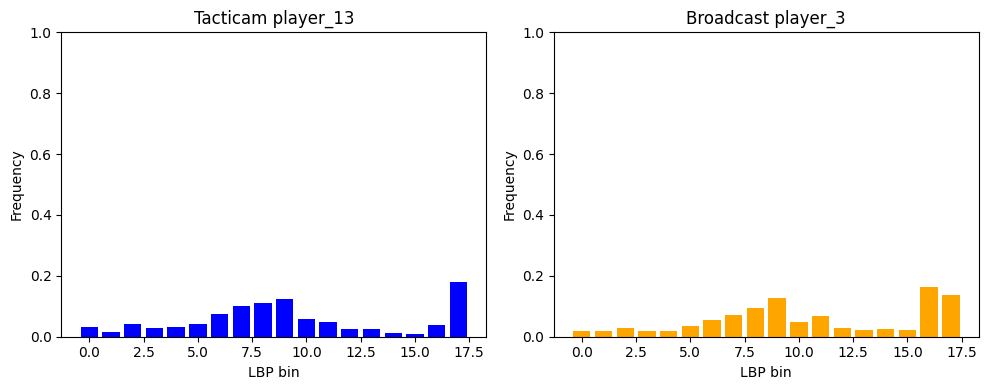

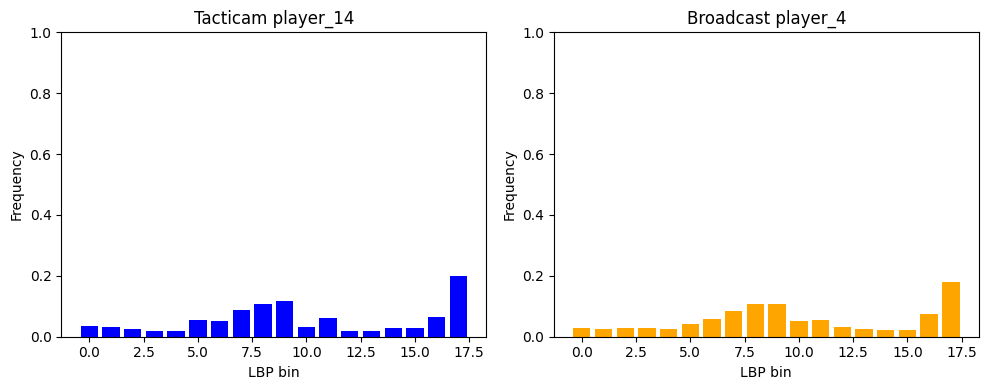

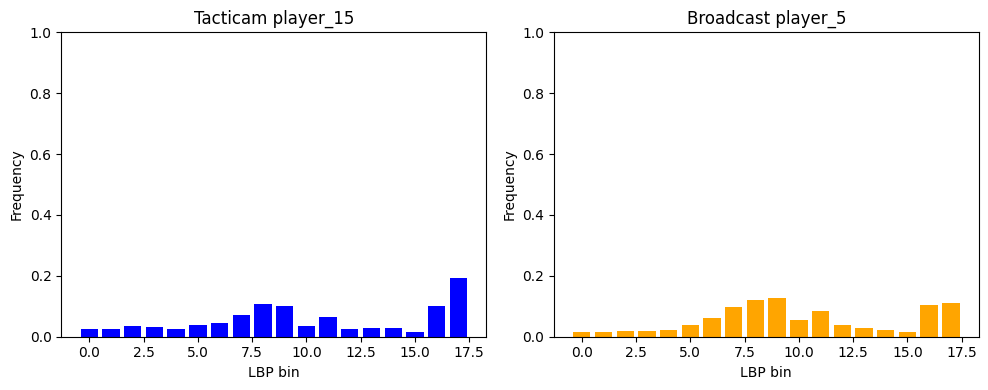

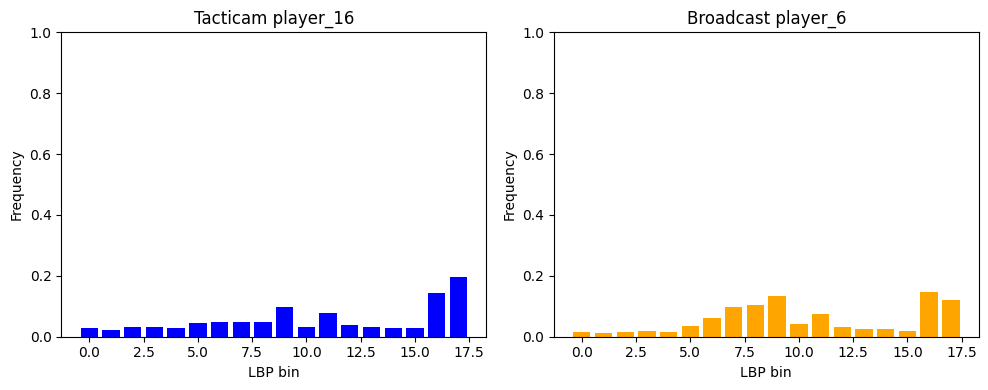

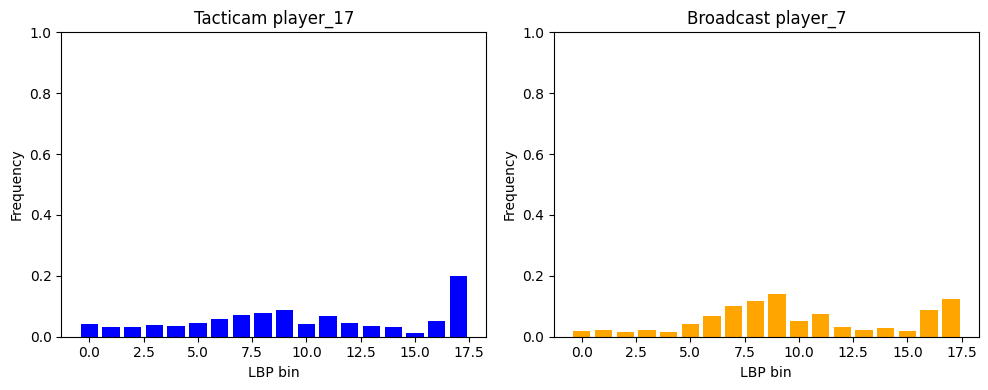

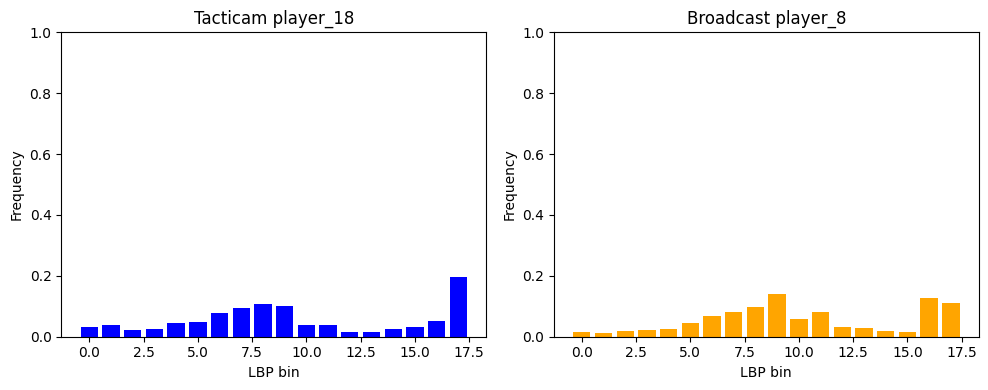

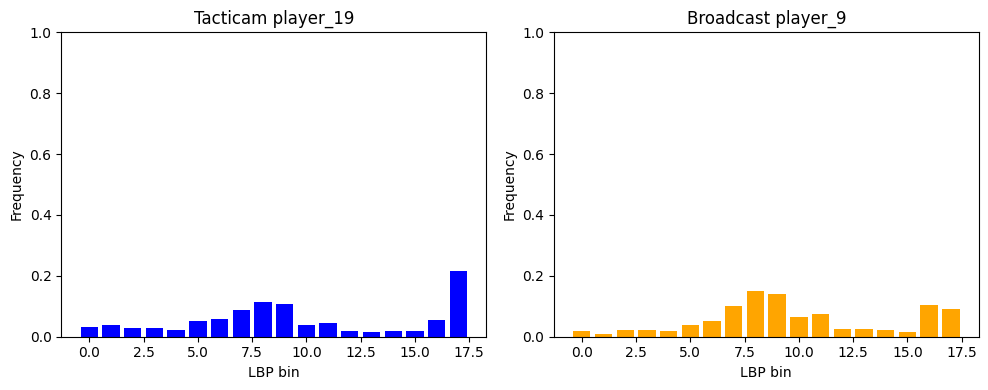

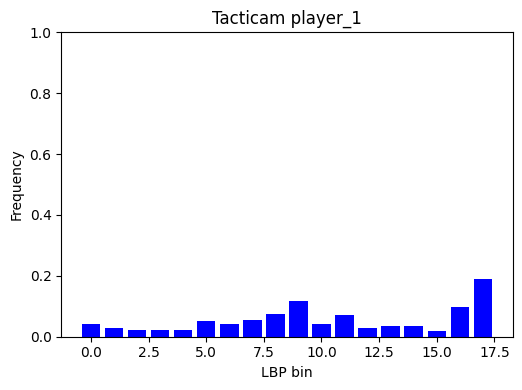

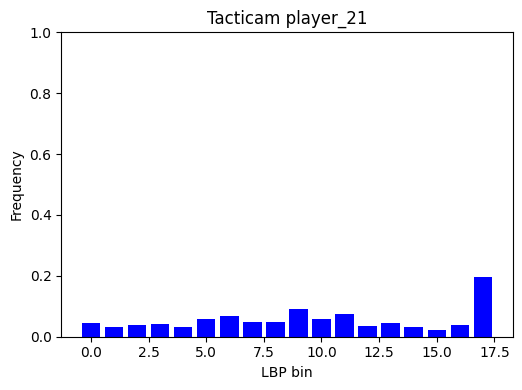

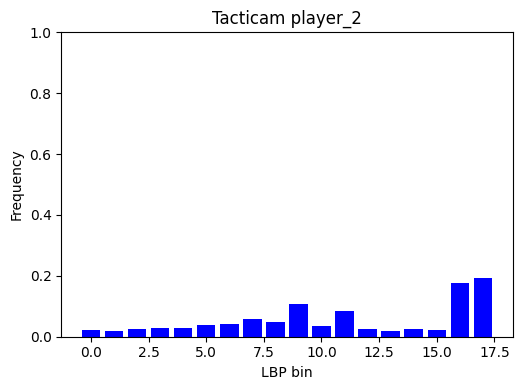

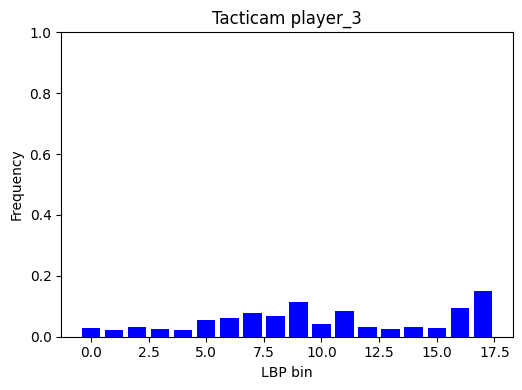

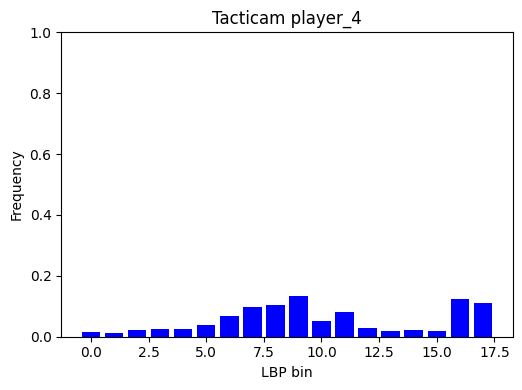

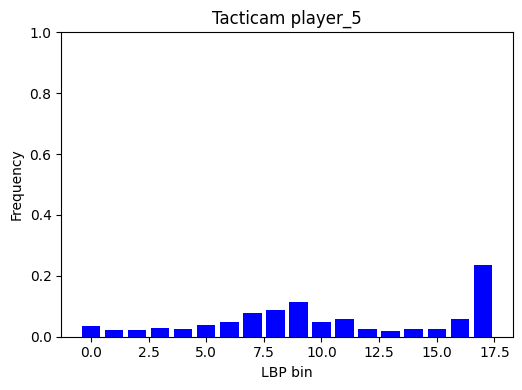

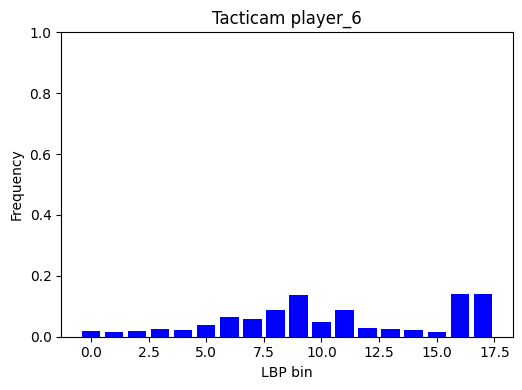

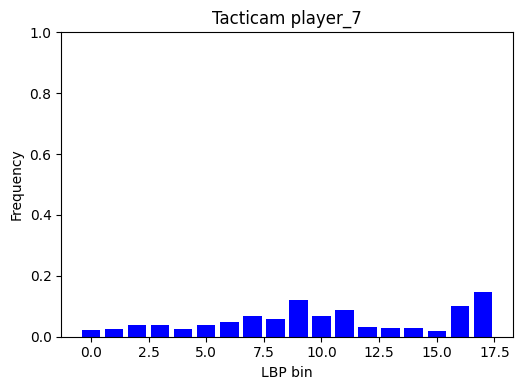

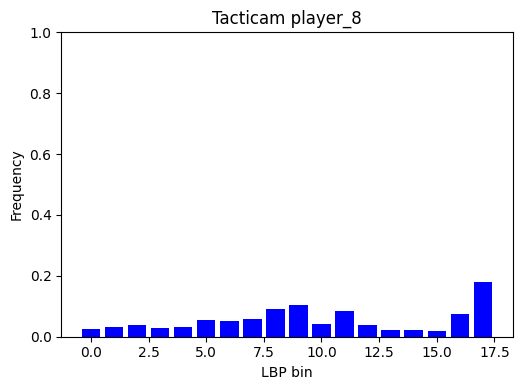

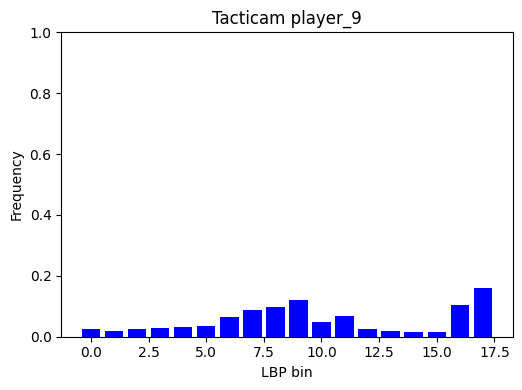

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Set frame directories
frame_dir_tacticam = "saved_LBP_tacticam/frame_0"
frame_dir_broadcast = "saved_LBP_broadcast/frame_0"

def load_lbp_histograms(frame_dir):
    hists = []
    names = []
    for file in sorted(os.listdir(frame_dir)):
        if file.endswith("_lbp.npy"):
            path = os.path.join(frame_dir, file)
            hist = np.load(path)
            hists.append(hist)
            names.append(file.replace("_lbp.npy", ""))
    return hists, names

# Load LBP histograms
hists_tacticam, names_tacticam = load_lbp_histograms(frame_dir_tacticam)
hists_broadcast, names_broadcast = load_lbp_histograms(frame_dir_broadcast)

num_players = max(len(hists_tacticam), len(hists_broadcast))

for i in range(num_players):
    plt.figure(figsize=(10, 4))
    if i < len(hists_tacticam):
        plt.subplot(1, 2, 1)
        plt.bar(range(len(hists_tacticam[i])), hists_tacticam[i], color='blue')
        plt.title(f"Tacticam {names_tacticam[i]}")
        plt.xlabel("LBP bin")
        plt.ylabel("Frequency")
        plt.ylim(0, 1)
    if i < len(hists_broadcast):
        plt.subplot(1, 2, 2)
        plt.bar(range(len(hists_broadcast[i])), hists_broadcast[i], color='orange')
        plt.title(f"Broadcast {names_broadcast[i]}")
        plt.xlabel("LBP bin")
        plt.ylabel("Frequency")
        plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

### visulaising using confucion matrix

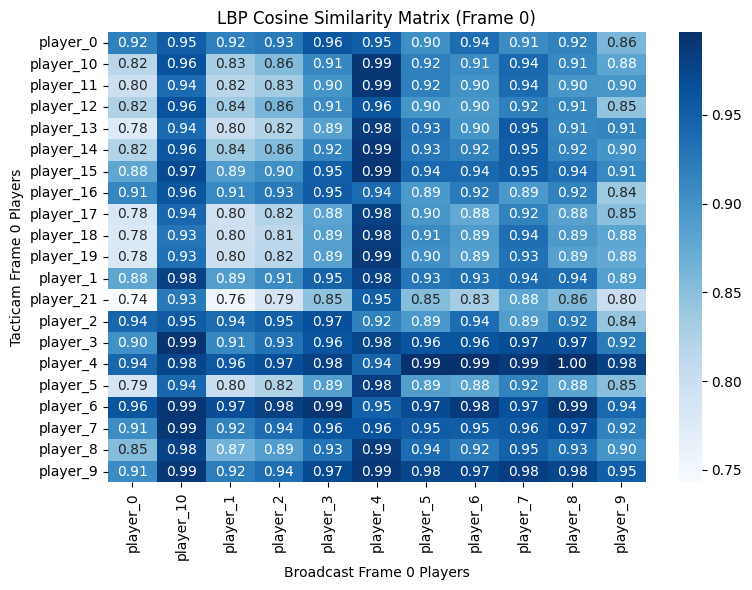

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def load_lbp_histograms(frame_dir):
    hists = []
    names = []
    for file in sorted(os.listdir(frame_dir)):
        if file.endswith("_lbp.npy"):
            path = os.path.join(frame_dir, file)
            hist = np.load(path)
            hists.append(hist)
            names.append(file.replace("_lbp.npy", ""))
    return hists, names

def plot_lbp_confusion_matrix(frame_dir_tacticam, frame_dir_broadcast):
    # Load LBP histograms
    hists_tacticam, names_tacticam = load_lbp_histograms(frame_dir_tacticam)
    hists_broadcast, names_broadcast = load_lbp_histograms(frame_dir_broadcast)

    # Convert to numpy arrays for sklearn
    X = np.stack(hists_tacticam) if hists_tacticam else np.empty((0,0))
    Y = np.stack(hists_broadcast) if hists_broadcast else np.empty((0,0))

    # Compute cosine similarity
    if X.size > 0 and Y.size > 0:
        sim_matrix = cosine_similarity(X, Y)
    else:
        sim_matrix = np.zeros((len(hists_tacticam), len(hists_broadcast)))

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=names_broadcast, yticklabels=names_tacticam)
    plt.xlabel("Broadcast Frame 0 Players")
    plt.ylabel("Tacticam Frame 0 Players")
    plt.title("LBP Cosine Similarity Matrix (Frame 0)")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_lbp_confusion_matrix(
    "saved_LBP_tacticam/frame_0",
    "saved_LBP_broadcast/frame_0"
)

# 3) LBP with color histogram

In [8]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from skimage.feature import local_binary_pattern

# ----- CONFIG -----
video_path = "dataset/tacticam.mp4"
output_dir = "saved_LBP_HSV_tacticam"
model = YOLO("model/best.pt")
max_frames = 5

cap = cv2.VideoCapture(video_path)
os.makedirs(output_dir, exist_ok=True)
frame_count = 0
font = cv2.FONT_HERSHEY_SIMPLEX

# LBP parameters
radius = 2
n_points = 8 * radius
METHOD = 'uniform'

while frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        print("End of video.")
        break

    result = model.predict(source=frame, conf=0.75, save=False, verbose=False)[0]
    annotated = frame.copy()
    frame_dir = os.path.join(output_dir, f"frame_{frame_count}")
    os.makedirs(frame_dir, exist_ok=True)

    boxes = result.boxes
    if boxes is not None:
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cls_id = int(box.cls[0].item())
            class_name = model.names[cls_id]

            if class_name.lower() != "player":
                continue

            crop = frame[y1:y2, x1:x2]

            # --- LBP ---
            gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            lbp = local_binary_pattern(gray_crop, n_points, radius, METHOD)
            (lbp_hist, _) = np.histogram(lbp.ravel(),
                                         bins=np.arange(0, n_points + 3),
                                         range=(0, n_points + 2))
            lbp_hist = lbp_hist.astype("float")
            lbp_hist /= (lbp_hist.sum() + 1e-7)
            lbp_path = os.path.join(frame_dir, f"player_{i}_lbp.npy")
            np.save(lbp_path, lbp_hist)

            # --- HSV Color Histogram ---
            hsv_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
            # 8 bins for H, 8 for S, 8 for V (total 512)
            hsv_hist = cv2.calcHist([hsv_crop], [0, 1, 2], None, [8, 8, 8],
                                    [0, 180, 0, 256, 0, 256])
            hsv_hist = cv2.normalize(hsv_hist, hsv_hist).flatten()
            hsv_path = os.path.join(frame_dir, f"player_{i}_hsv.npy")
            np.save(hsv_path, hsv_hist)

            # Save crop
            crop_path = os.path.join(frame_dir, f"player_{i}.jpg")
            cv2.imwrite(crop_path, crop)

            # Annotate
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(annotated, f"Player {i}", (x1, y1 - 10), font, 0.6, (255, 0, 0), 2)

    # Save annotated frame
    frame_path = os.path.join(frame_dir, "annotated.jpg")
    cv2.imwrite(frame_path, annotated)

    print(f"[Frame {frame_count}] LBP+HSV Processed and saved.")
    frame_count += 1

cap.release()

[Frame 0] LBP+HSV Processed and saved.
[Frame 1] LBP+HSV Processed and saved.
[Frame 2] LBP+HSV Processed and saved.
[Frame 3] LBP+HSV Processed and saved.
[Frame 4] LBP+HSV Processed and saved.


In [9]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from skimage.feature import local_binary_pattern

# ----- CONFIG -----
video_path = "dataset/broadcast.mp4"
output_dir = "saved_LBP_HSV_broadcast"
model = YOLO("model/best.pt")
max_frames = 5

cap = cv2.VideoCapture(video_path)
os.makedirs(output_dir, exist_ok=True)
frame_count = 0
font = cv2.FONT_HERSHEY_SIMPLEX

# LBP parameters
radius = 2
n_points = 8 * radius
METHOD = 'uniform'

while frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        print("End of video.")
        break

    result = model.predict(source=frame, conf=0.75, save=False, verbose=False)[0]
    annotated = frame.copy()
    frame_dir = os.path.join(output_dir, f"frame_{frame_count}")
    os.makedirs(frame_dir, exist_ok=True)

    boxes = result.boxes
    if boxes is not None:
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cls_id = int(box.cls[0].item())
            class_name = model.names[cls_id]

            if class_name.lower() != "player":
                continue

            crop = frame[y1:y2, x1:x2]

            # --- LBP ---
            gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            lbp = local_binary_pattern(gray_crop, n_points, radius, METHOD)
            (lbp_hist, _) = np.histogram(lbp.ravel(),
                                         bins=np.arange(0, n_points + 3),
                                         range=(0, n_points + 2))
            lbp_hist = lbp_hist.astype("float")
            lbp_hist /= (lbp_hist.sum() + 1e-7)
            lbp_path = os.path.join(frame_dir, f"player_{i}_lbp.npy")
            np.save(lbp_path, lbp_hist)

            # --- HSV Color Histogram ---
            hsv_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
            # 8 bins for H, 8 for S, 8 for V (total 512)
            hsv_hist = cv2.calcHist([hsv_crop], [0, 1, 2], None, [8, 8, 8],
                                    [0, 180, 0, 256, 0, 256])
            hsv_hist = cv2.normalize(hsv_hist, hsv_hist).flatten()
            hsv_path = os.path.join(frame_dir, f"player_{i}_hsv.npy")
            np.save(hsv_path, hsv_hist)

            # Save crop
            crop_path = os.path.join(frame_dir, f"player_{i}.jpg")
            cv2.imwrite(crop_path, crop)

            # Annotate
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(annotated, f"Player {i}", (x1, y1 - 10), font, 0.6, (255, 0, 0), 2)

    # Save annotated frame
    frame_path = os.path.join(frame_dir, "annotated.jpg")
    cv2.imwrite(frame_path, annotated)

    print(f"[Frame {frame_count}] LBP+HSV Processed and saved.")
    frame_count += 1

cap.release()

[Frame 0] LBP+HSV Processed and saved.
[Frame 1] LBP+HSV Processed and saved.
[Frame 2] LBP+HSV Processed and saved.
[Frame 3] LBP+HSV Processed and saved.
[Frame 4] LBP+HSV Processed and saved.


### ploting histogra,

/var/folders/xb/sshzwv1128l88chp71np05t40000gn/T/ipykernel_32107/995908087.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 4))


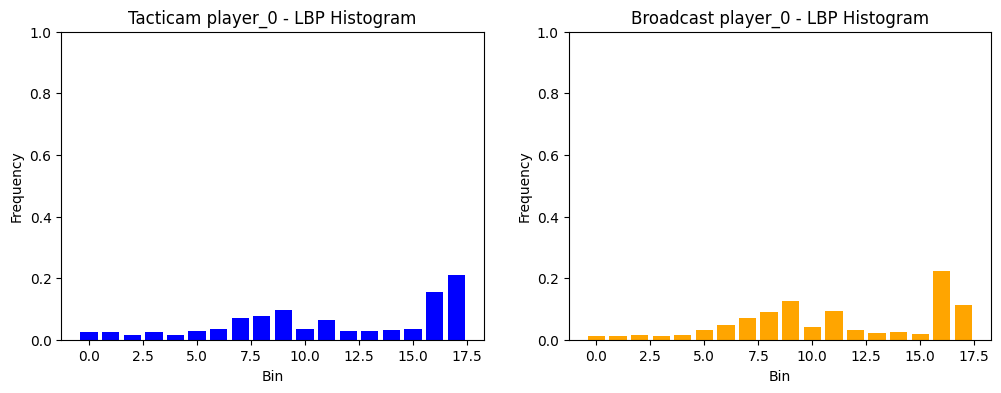

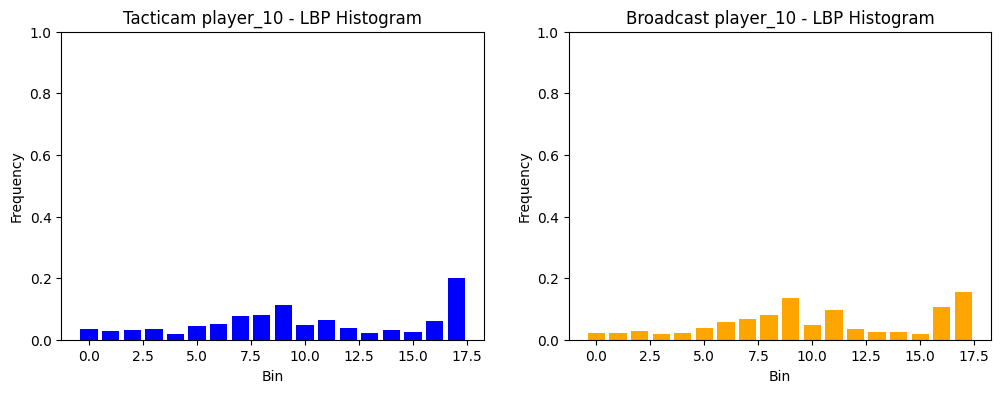

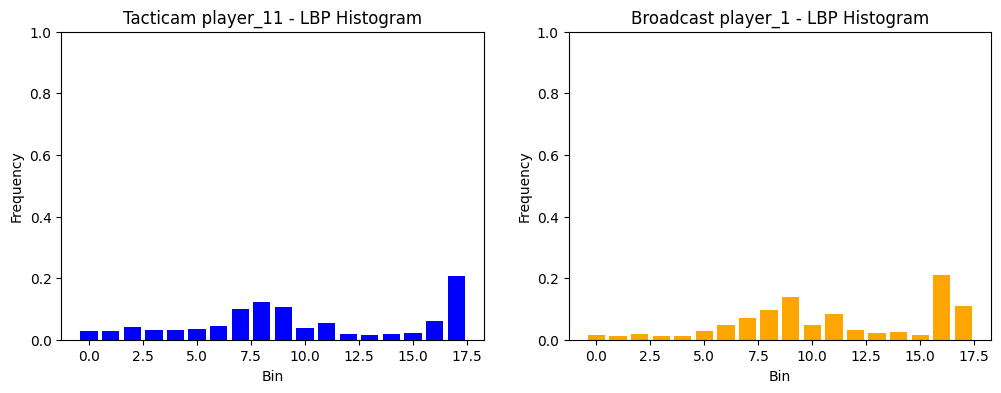

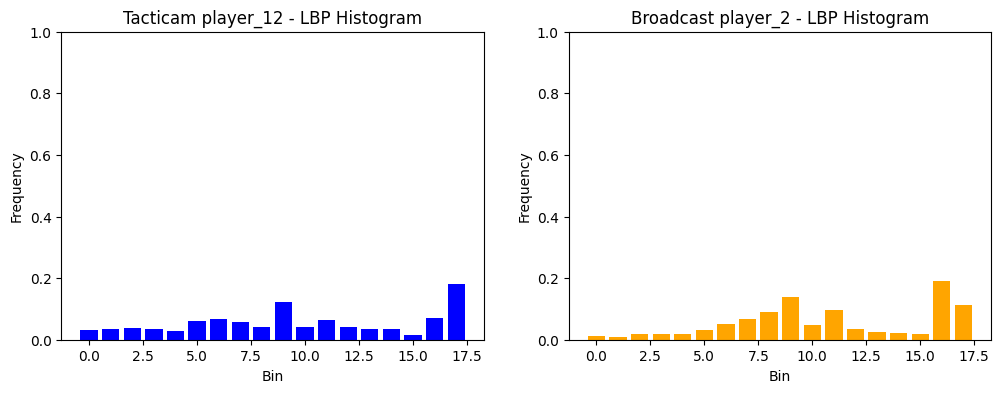

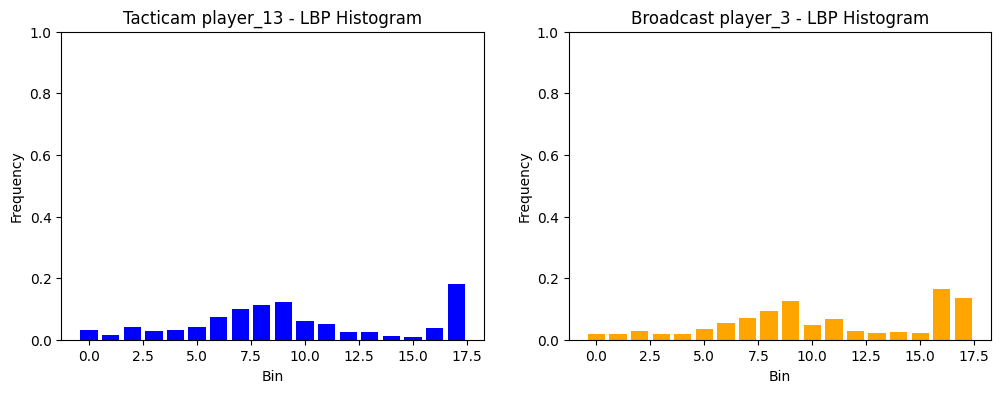

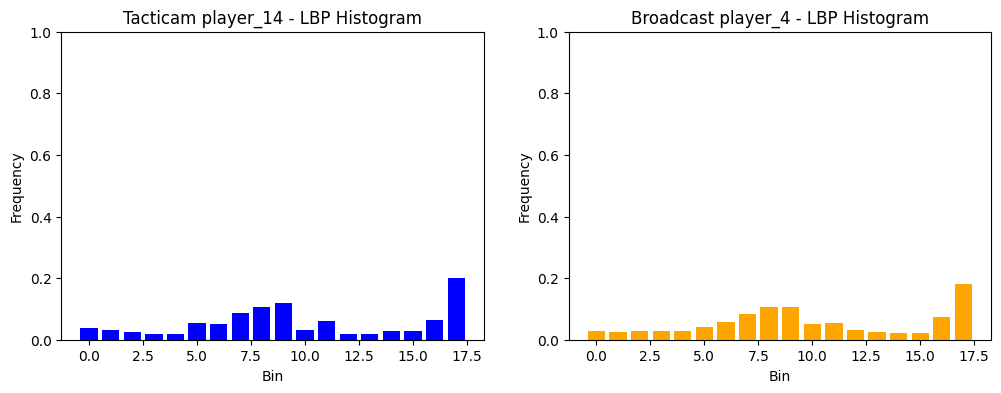

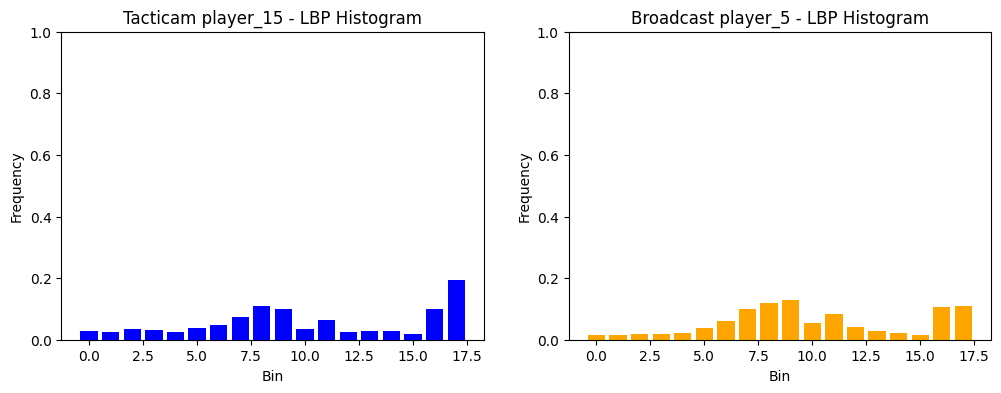

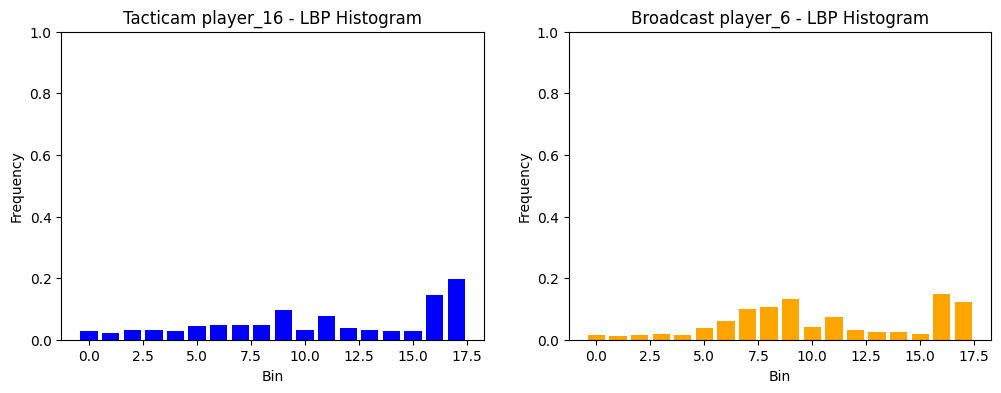

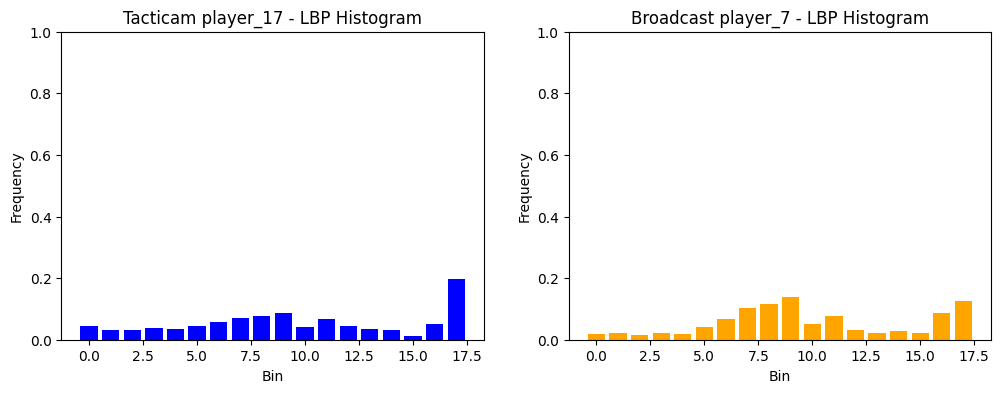

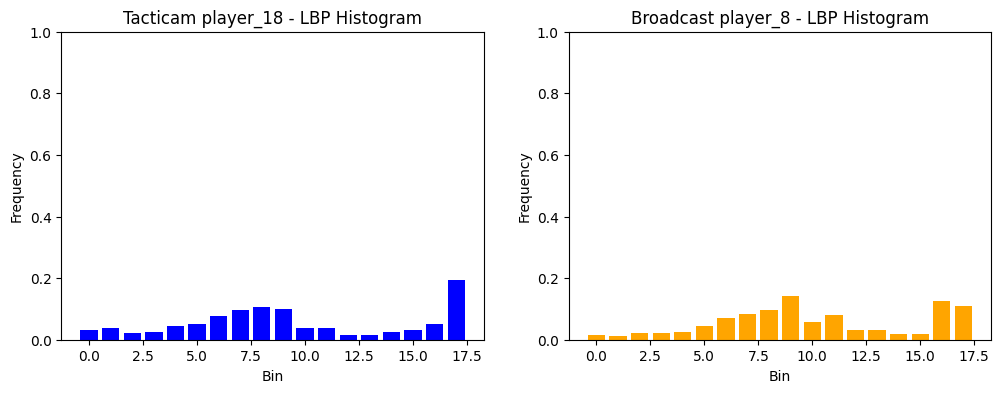

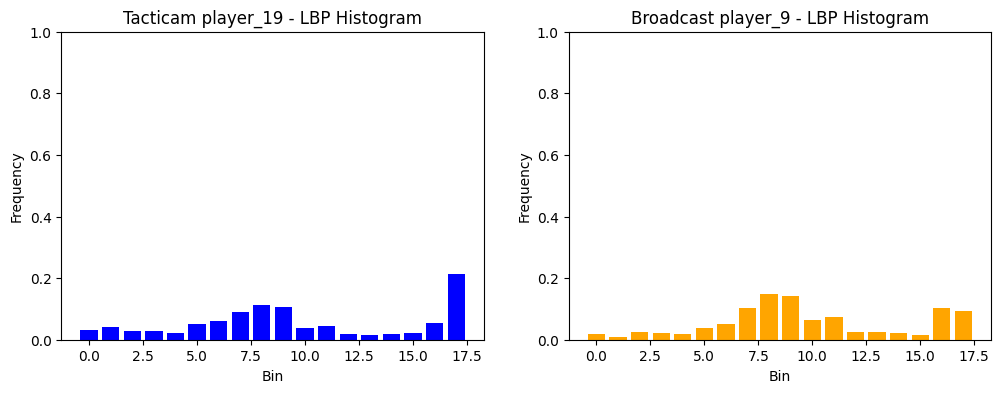

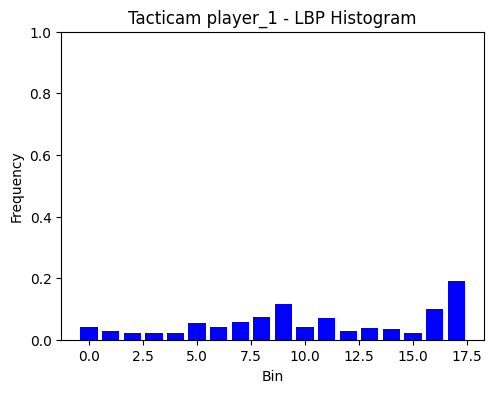

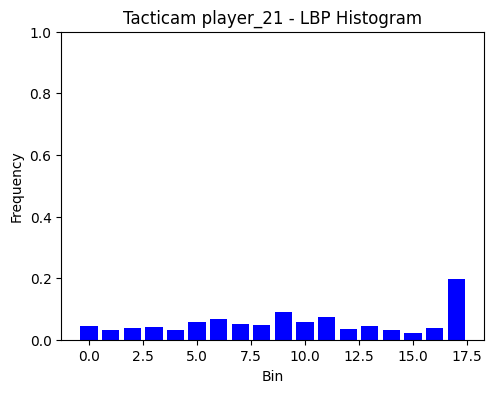

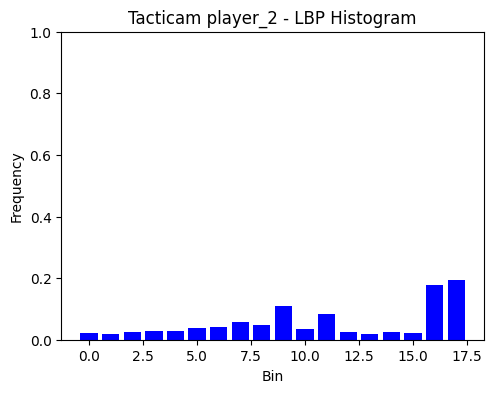

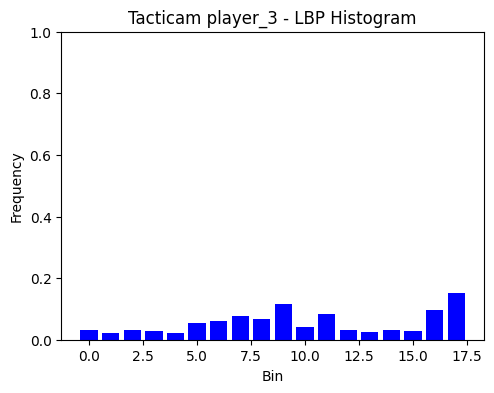

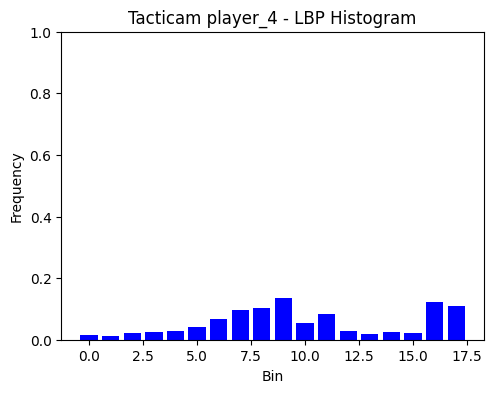

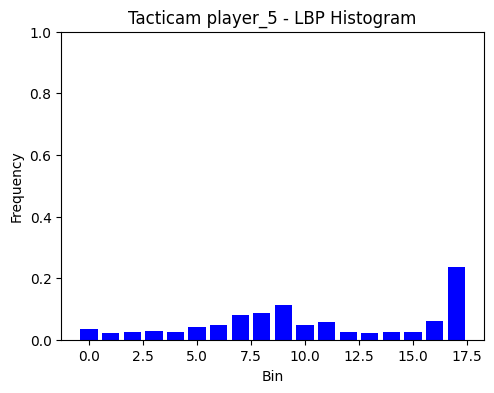

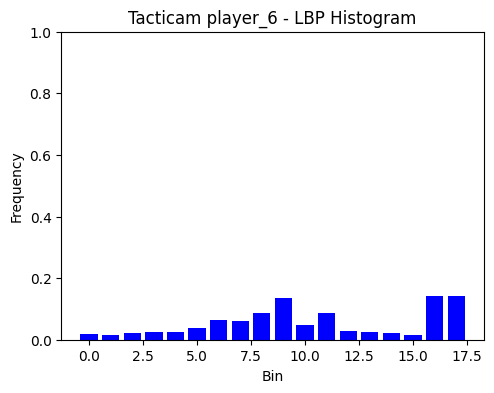

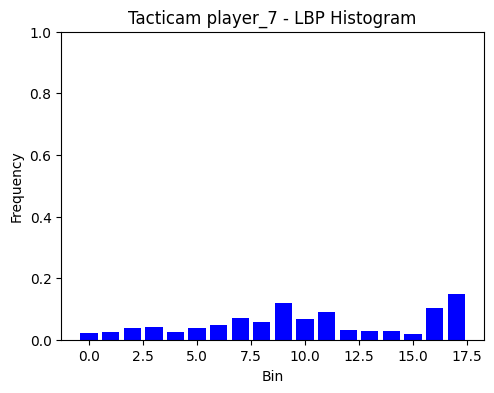

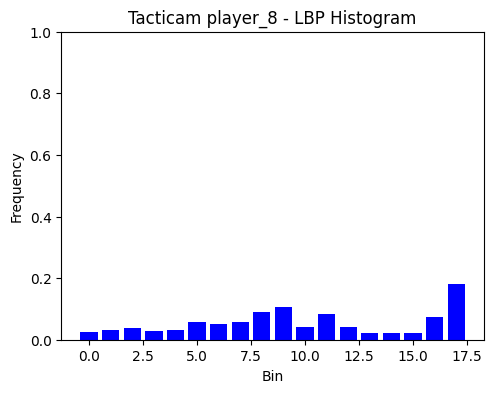

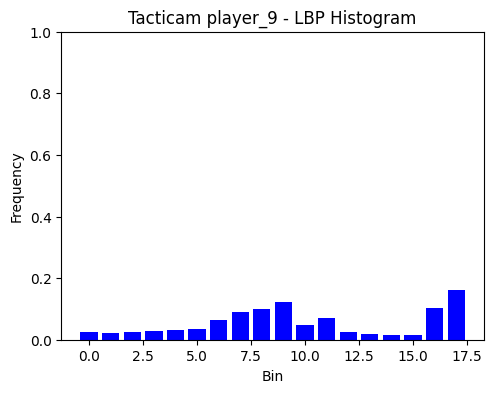

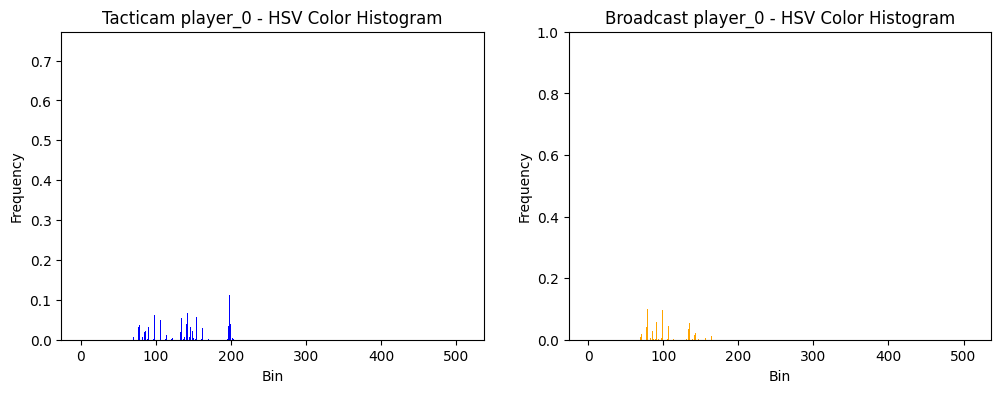

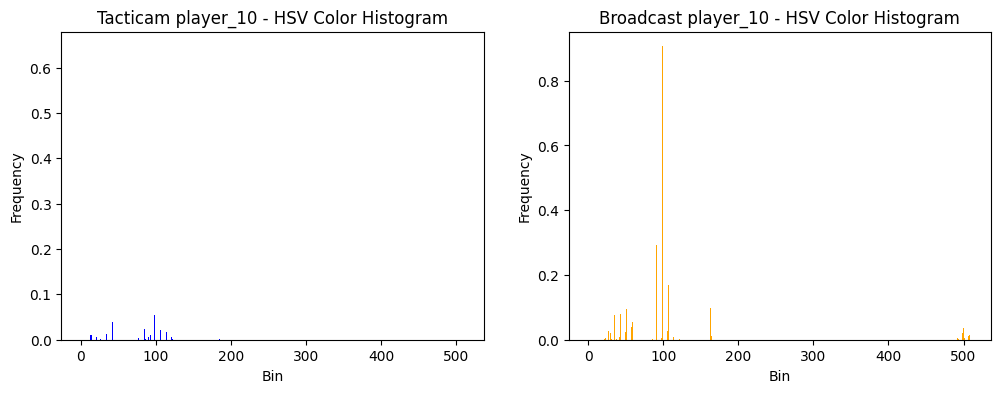

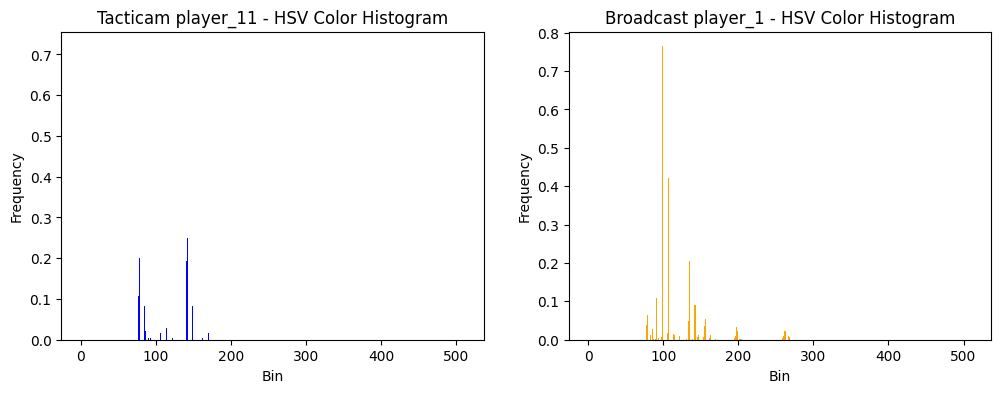

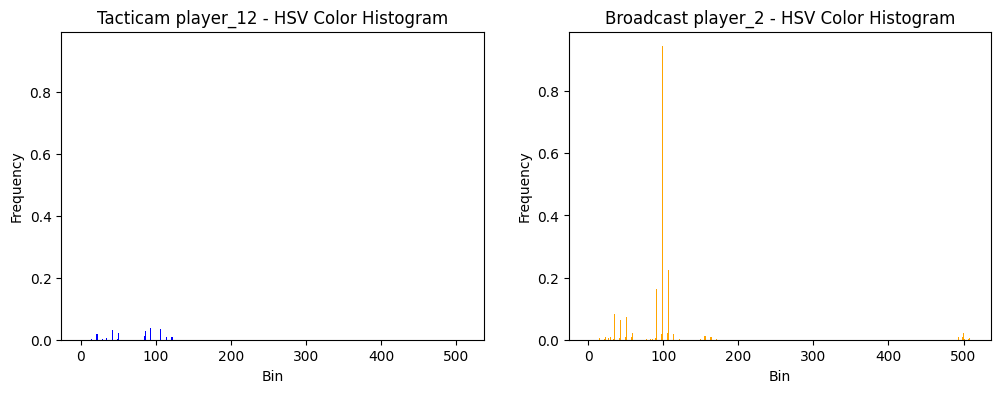

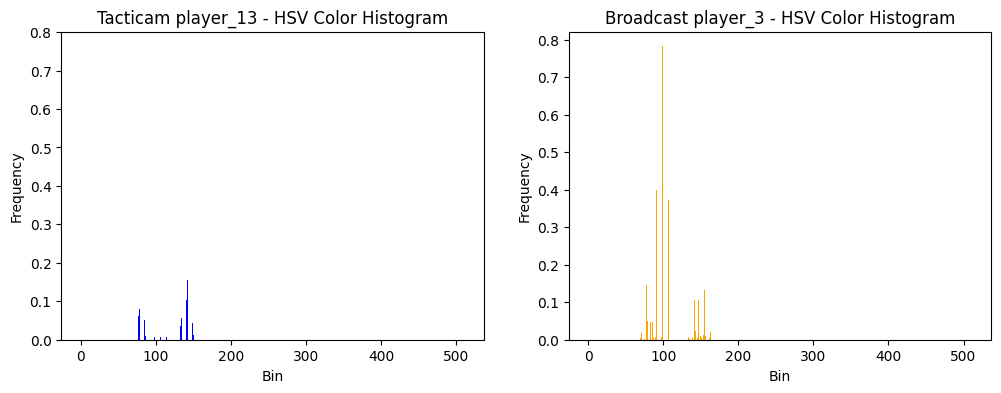

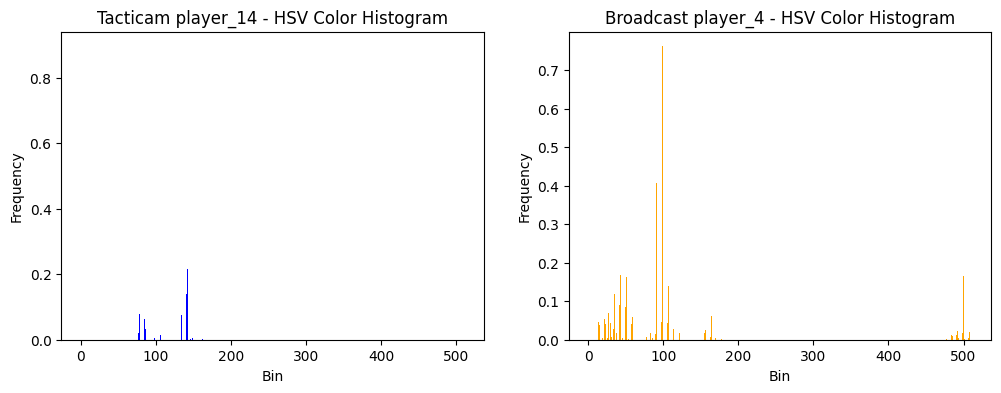

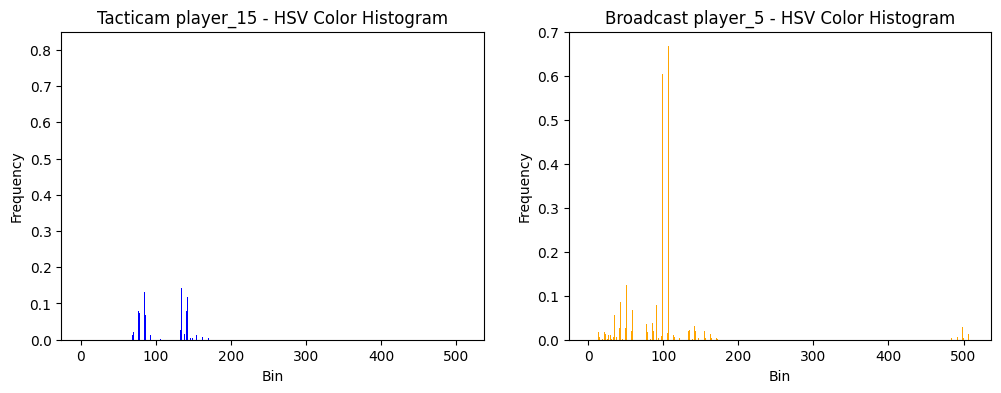

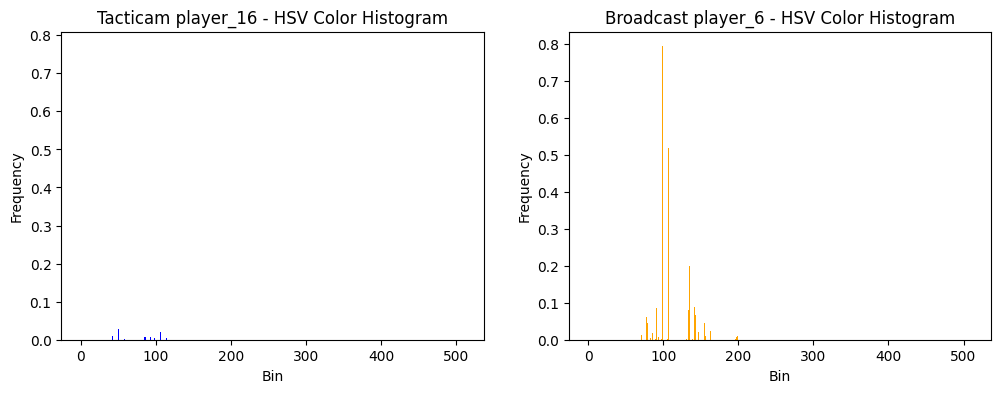

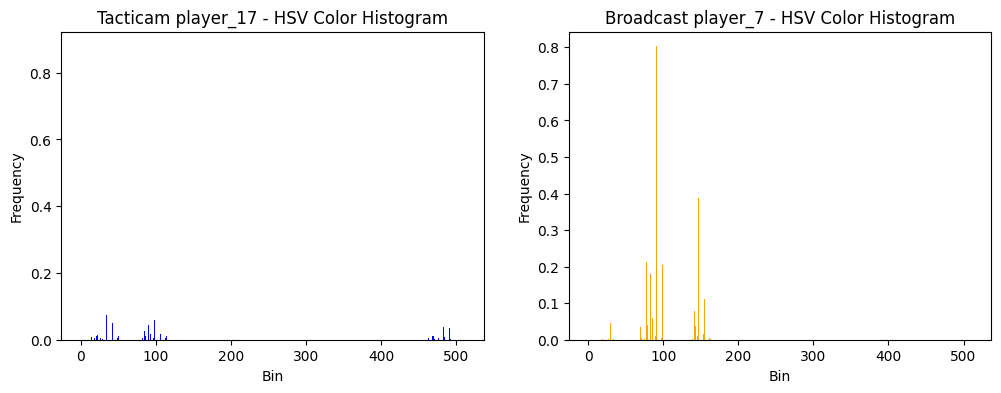

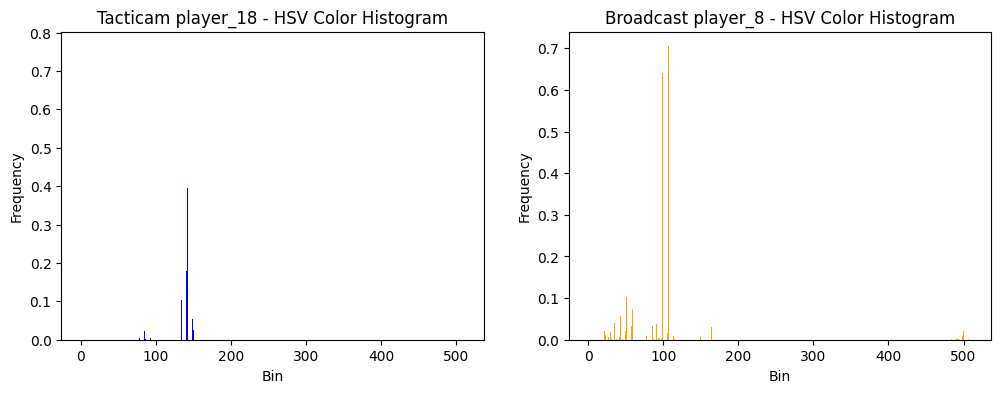

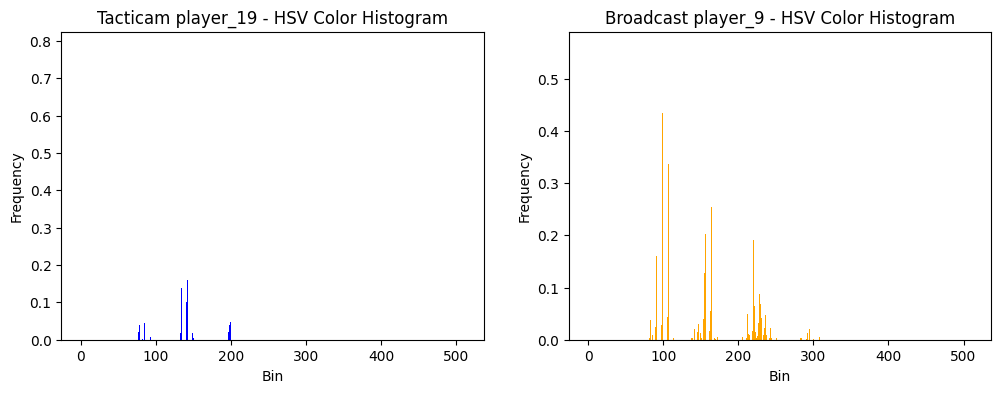

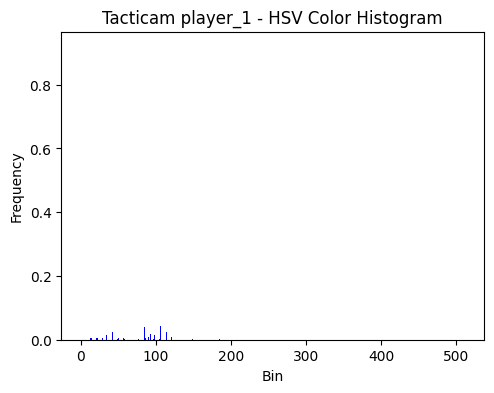

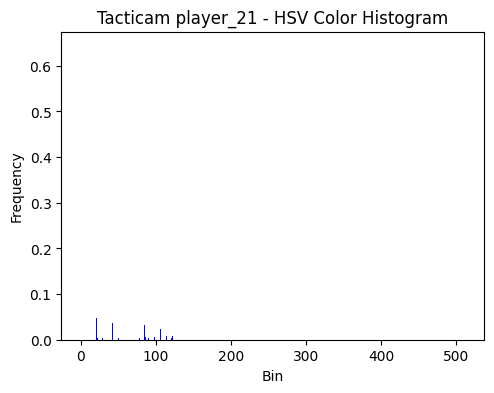

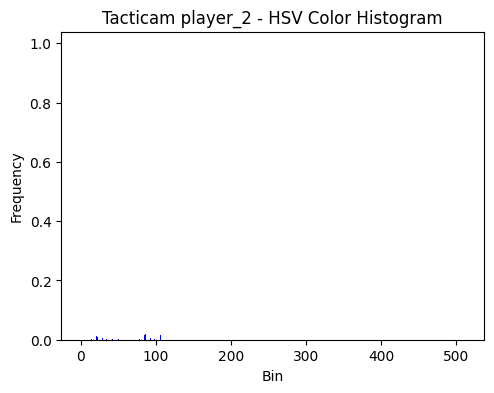

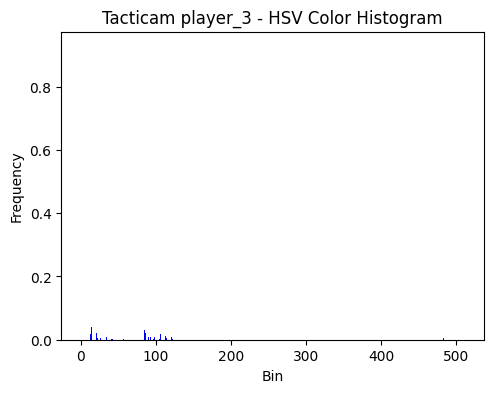

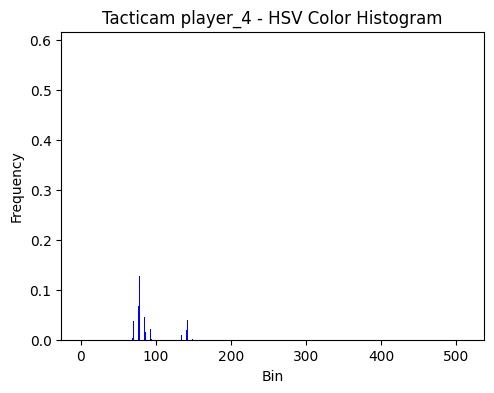

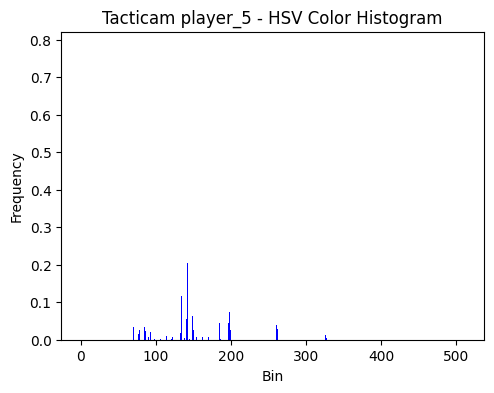

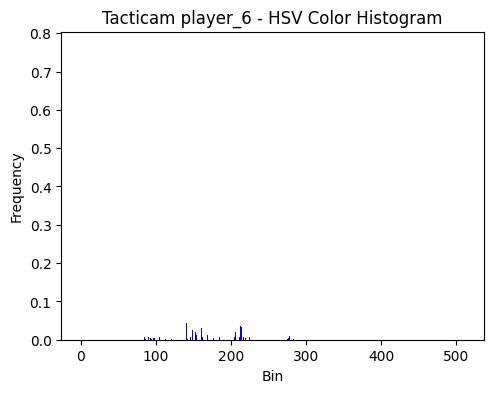

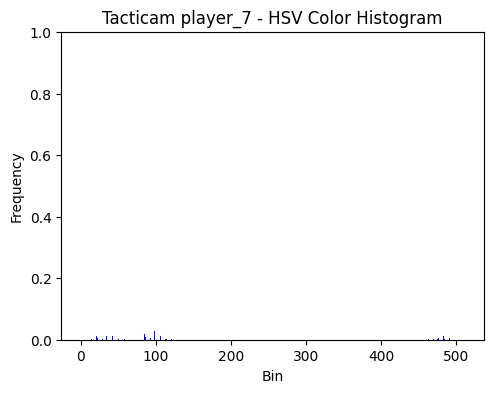

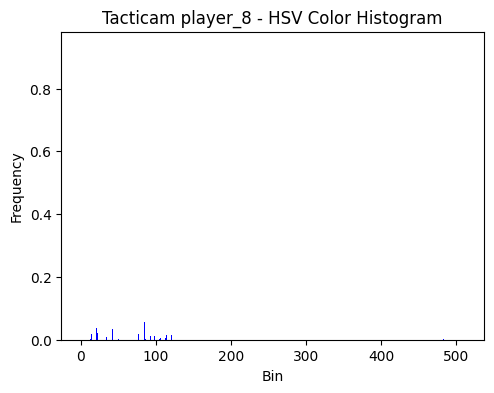

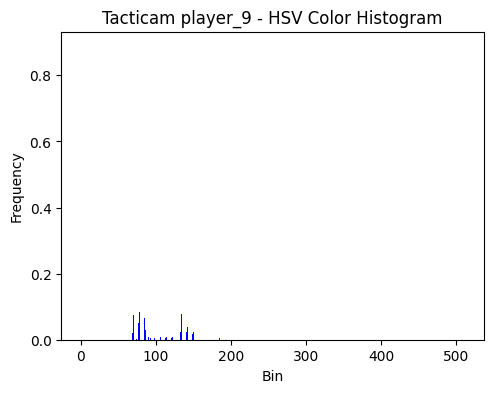

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_histograms(frame_dir, hist_type="_lbp.npy"):
    hists = []
    names = []
    for file in sorted(os.listdir(frame_dir)):
        if file.endswith(hist_type):
            path = os.path.join(frame_dir, file)
            hist = np.load(path)
            hists.append(hist)
            names.append(file.replace(hist_type, ""))
    return hists, names

frame_dir_tacticam = "saved_LBP_HSV_tacticam/frame_0"
frame_dir_broadcast = "saved_LBP_HSV_broadcast/frame_0"

# Plot LBP and HSV histograms for each player
for hist_type, title in [("_lbp.npy", "LBP Histogram"), ("_hsv.npy", "HSV Color Histogram")]:
    hists_tacticam, names_tacticam = load_histograms(frame_dir_tacticam, hist_type)
    hists_broadcast, names_broadcast = load_histograms(frame_dir_broadcast, hist_type)
    num_players = max(len(hists_tacticam), len(hists_broadcast))

    for i in range(num_players):
        plt.figure(figsize=(12, 4))
        if i < len(hists_tacticam):
            plt.subplot(1, 2, 1)
            plt.bar(range(len(hists_tacticam[i])), hists_tacticam[i], color='blue')
            plt.title(f"Tacticam {names_tacticam[i]} - {title}")
            plt.xlabel("Bin")
            plt.ylabel("Frequency")
            if hist_type == "_lbp.npy":
                plt.ylim(0, 1)
        if i < len(hists_broadcast):
            plt.subplot(1, 2, 2)
            plt.bar(range(len(hists_broadcast[i])), hists_broadcast[i], color='orange')
            plt.title(f"Broadcast {names_broadcast[i]} - {title}")
            plt.xlabel("Bin")
            plt.ylabel("Frequency")
            if hist_type == "_lbp.npy":
                plt.ylim(0, 1)

### ploting a mathemcatical linear combination of LBP and color histogram

/var/folders/xb/sshzwv1128l88chp71np05t40000gn/T/ipykernel_32107/992371897.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(14, 4))


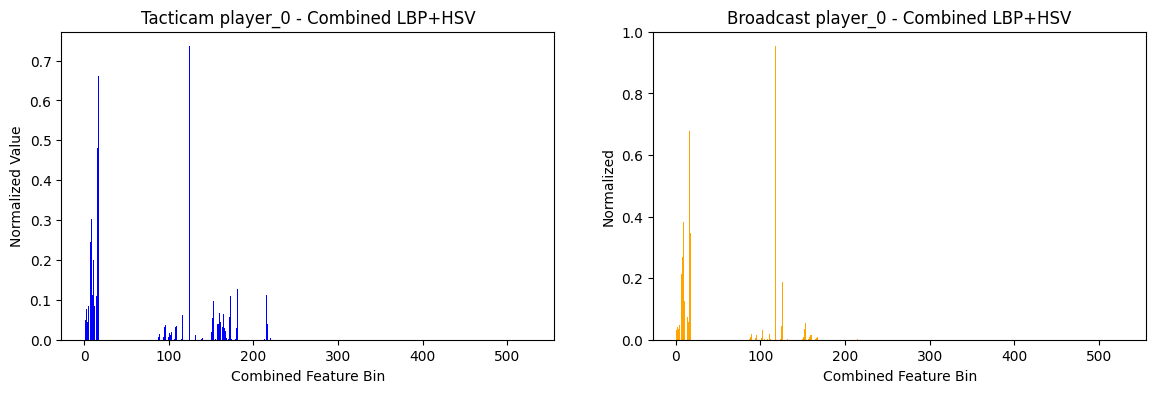

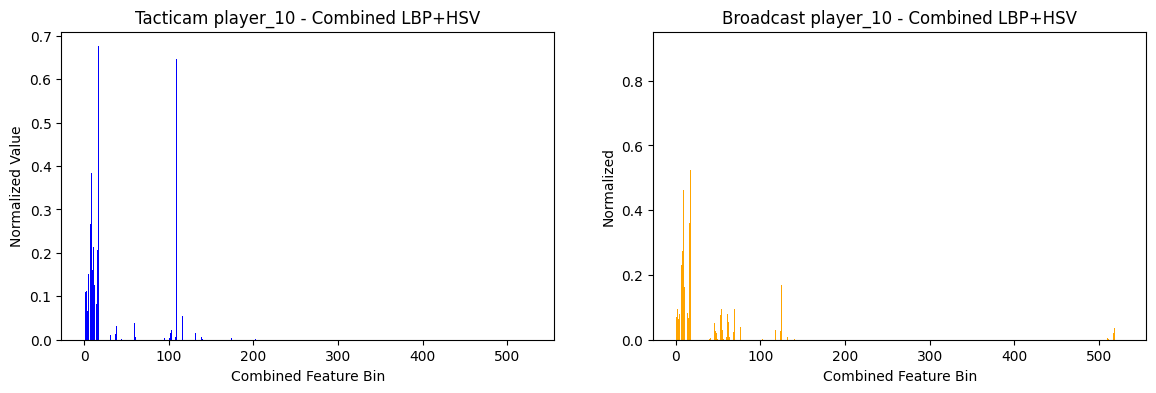

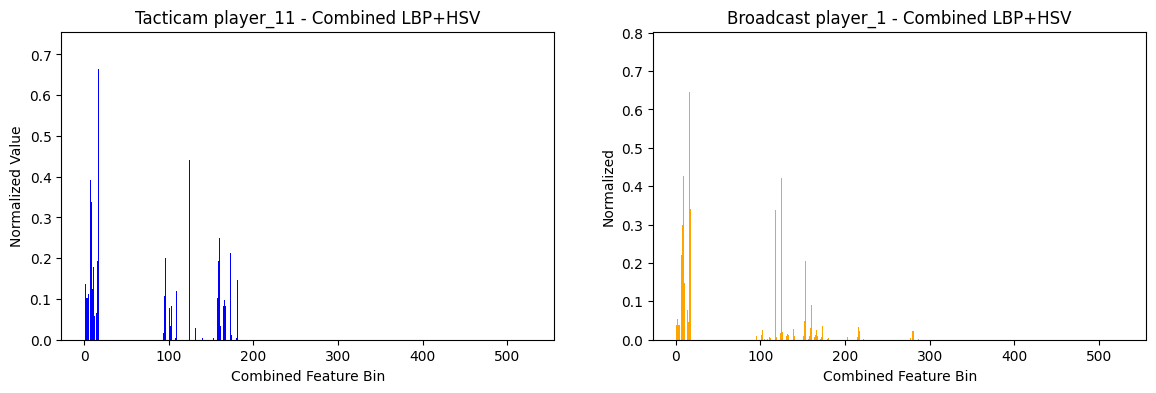

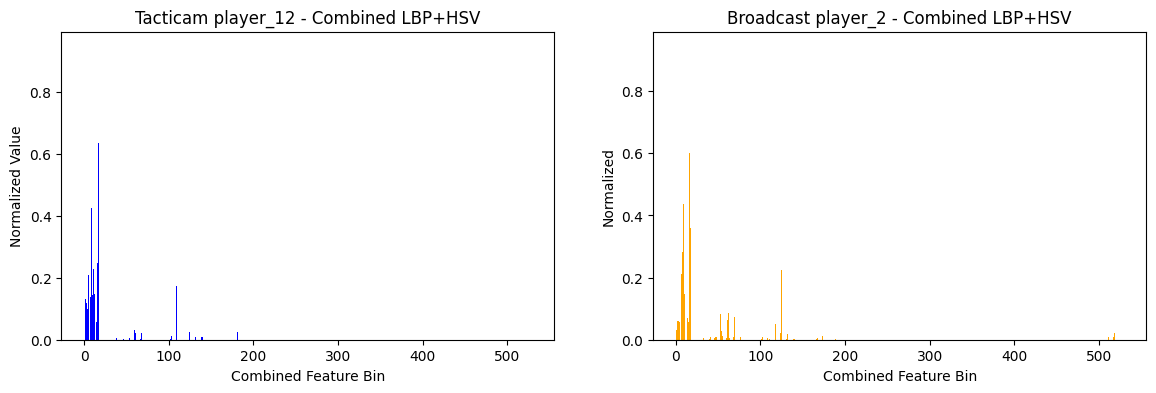

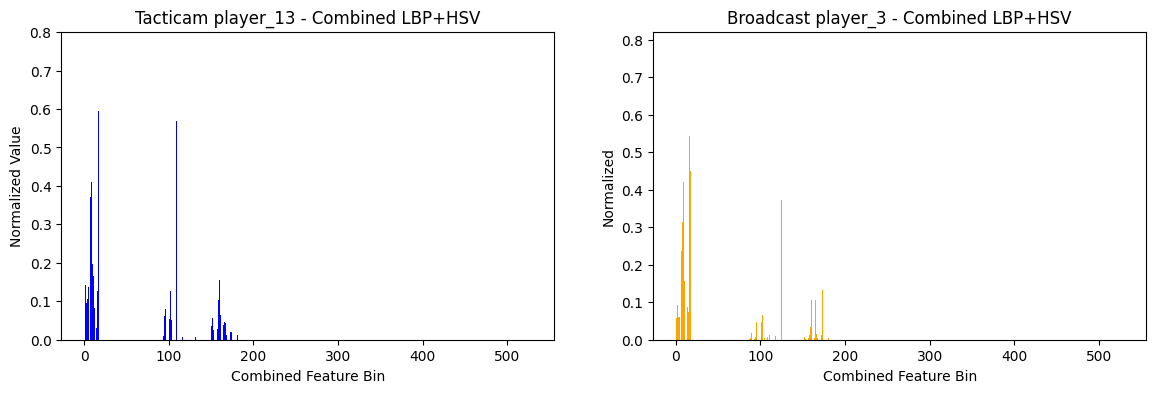

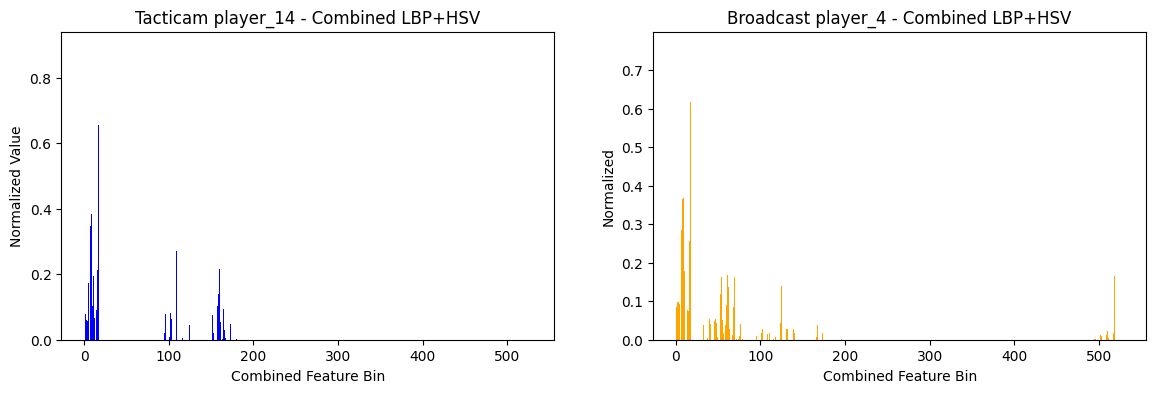

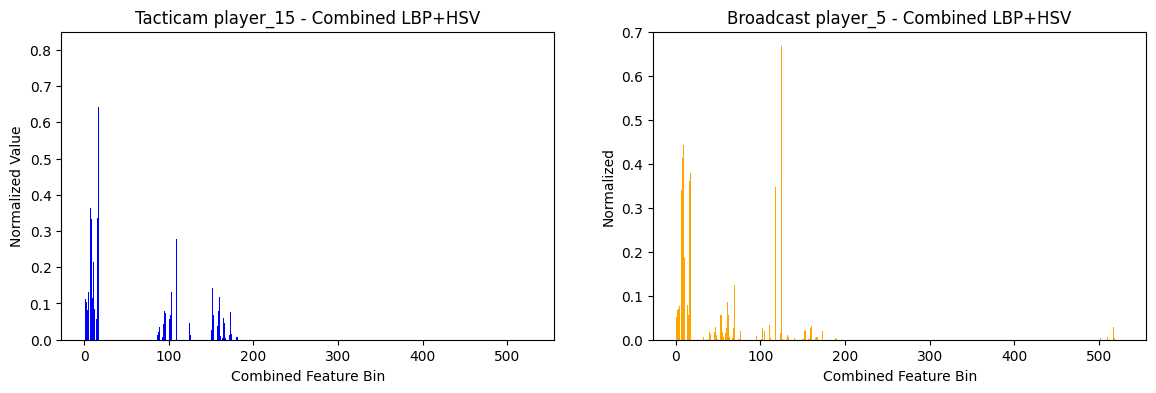

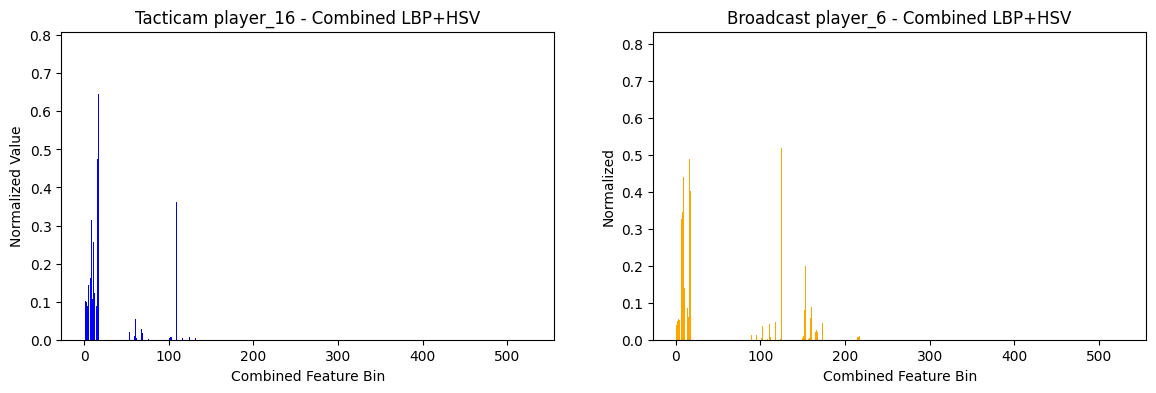

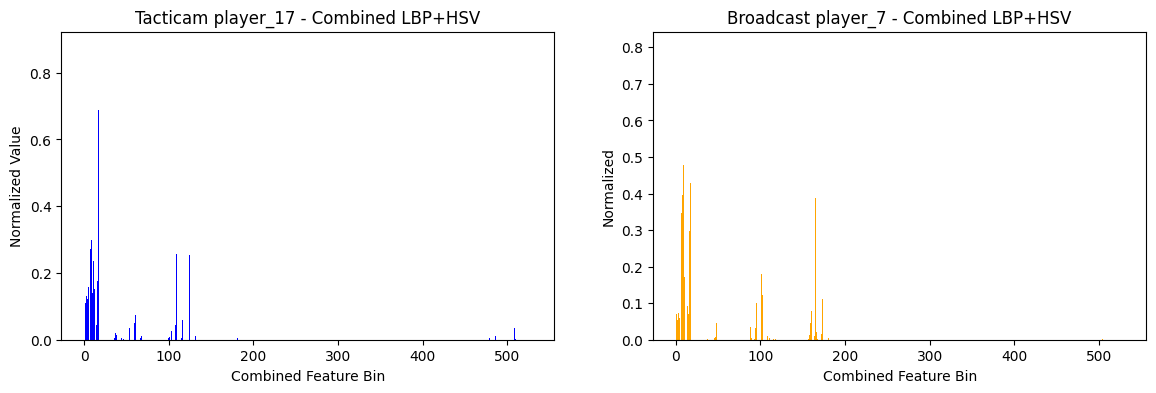

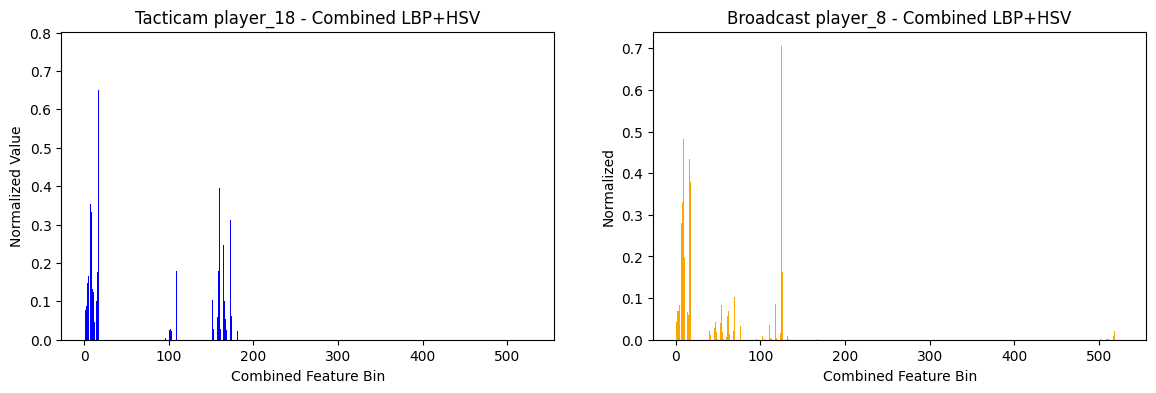

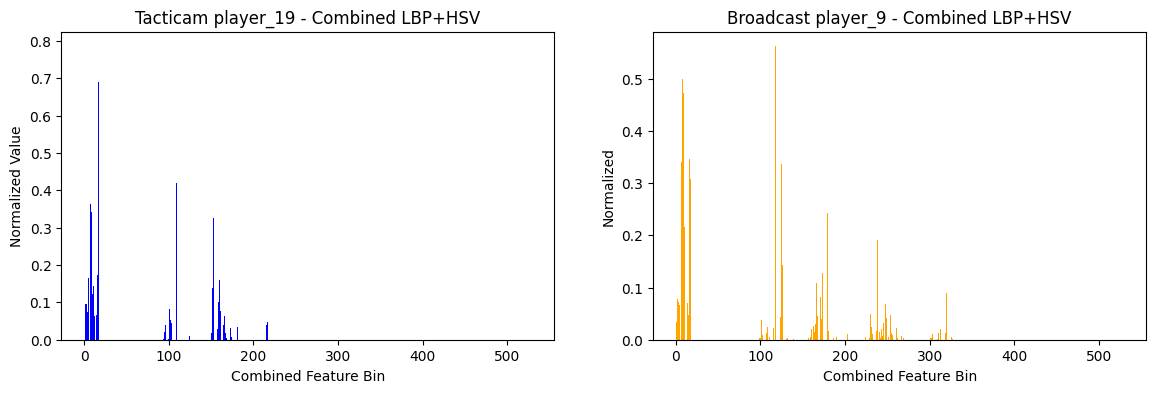

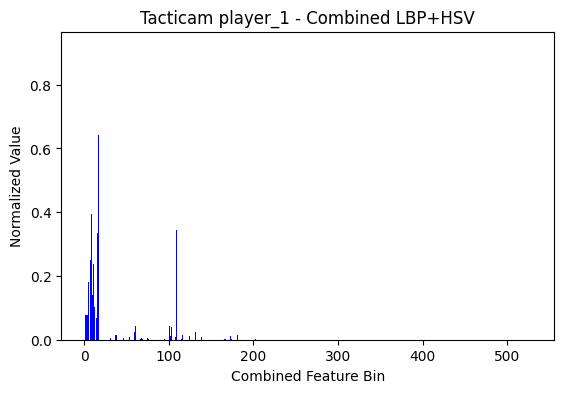

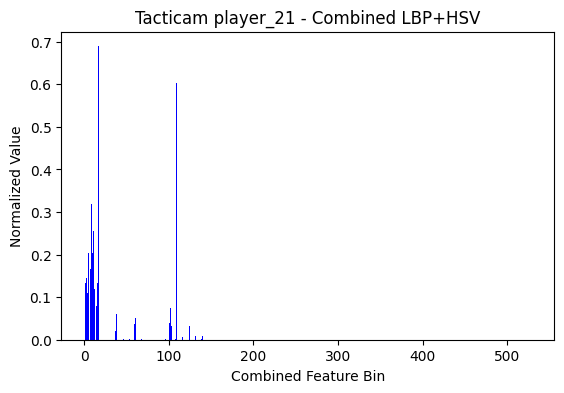

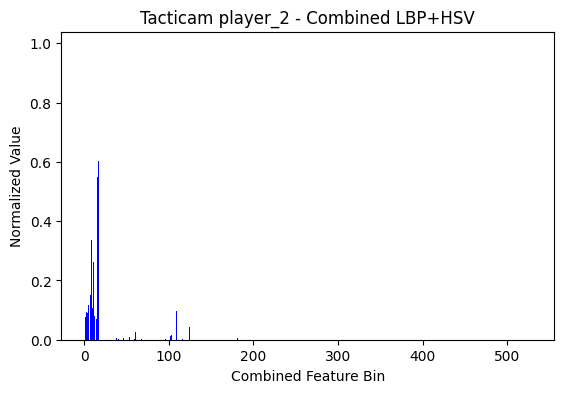

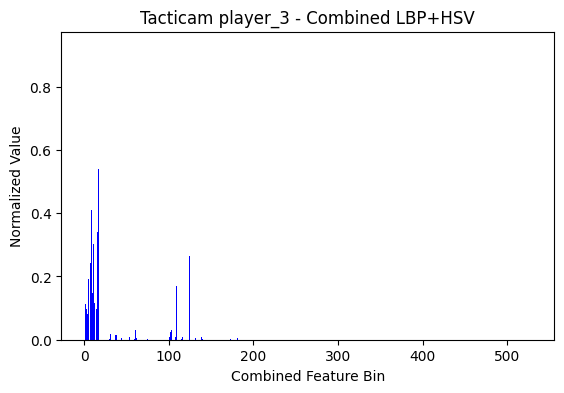

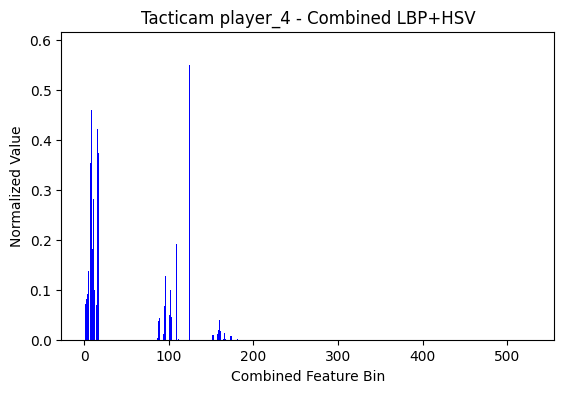

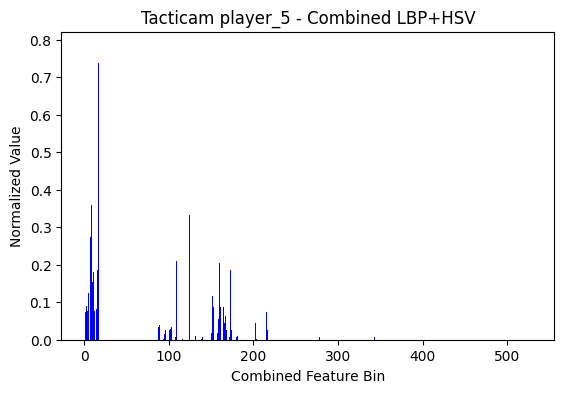

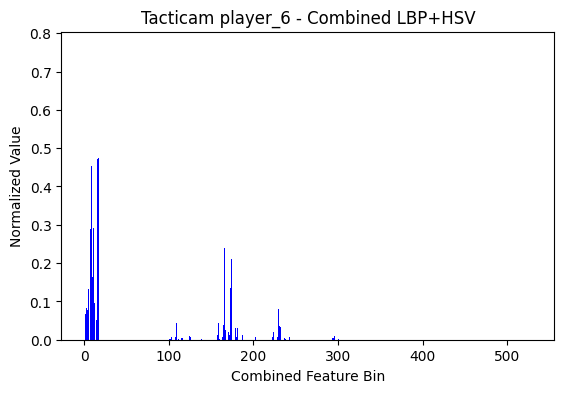

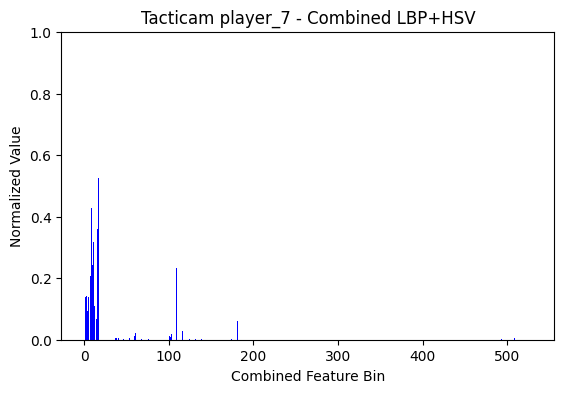

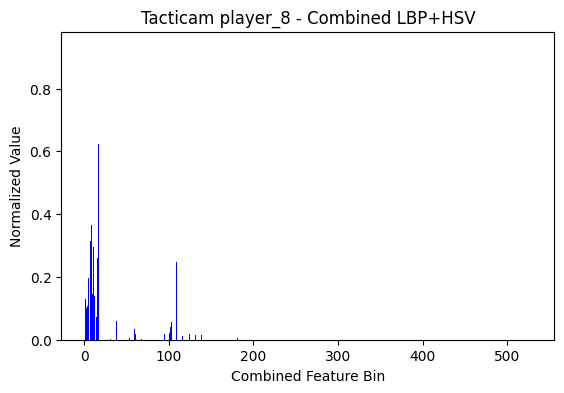

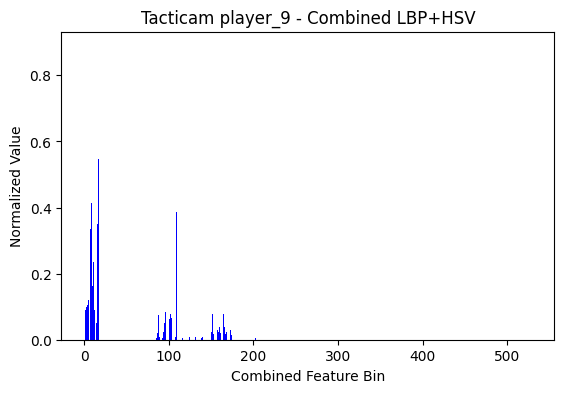

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_histograms(frame_dir, hist_type):
    hists = []
    names = []
    for file in sorted(os.listdir(frame_dir)):
        if file.endswith(hist_type):
            path = os.path.join(frame_dir, file)
            hist = np.load(path)
            hists.append(hist)
            names.append(file.replace(hist_type, ""))
    return hists, names

frame_dir_tacticam = "saved_LBP_HSV_tacticam/frame_0"
frame_dir_broadcast = "saved_LBP_HSV_broadcast/frame_0"

# Load both LBP and HSV histograms
lbp_tac, names_tac = load_histograms(frame_dir_tacticam, "_lbp.npy")
hsv_tac, _ = load_histograms(frame_dir_tacticam, "_hsv.npy")
lbp_brd, names_brd = load_histograms(frame_dir_broadcast, "_lbp.npy")
hsv_brd, _ = load_histograms(frame_dir_broadcast, "_hsv.npy")

# Combine (concatenate) LBP and HSV for each player
def combine_features(lbp_list, hsv_list):
    combined = []
    for lbp, hsv in zip(lbp_list, hsv_list):
        # Normalize each part before concatenation for fair contribution
        lbp_norm = lbp / (np.linalg.norm(lbp) + 1e-8)
        hsv_norm = hsv / (np.linalg.norm(hsv) + 1e-8)
        combined.append(np.concatenate([lbp_norm, hsv_norm]))
    return combined

combined_tac = combine_features(lbp_tac, hsv_tac)
combined_brd = combine_features(lbp_brd, hsv_brd)

num_players = max(len(combined_tac), len(combined_brd))

# Plot combined histograms for each player
for i in range(num_players):
    plt.figure(figsize=(14, 4))
    if i < len(combined_tac):
        plt.subplot(1, 2, 1)
        plt.bar(range(len(combined_tac[i])), combined_tac[i], color='blue')
        plt.title(f"Tacticam {names_tac[i]} - Combined LBP+HSV")
        plt.xlabel("Combined Feature Bin")
        plt.ylabel("Normalized Value")
    if i < len(combined_brd):
        plt.subplot(1, 2, 2)
        plt.bar(range(len(combined_brd[i])), combined_brd[i], color='orange')
        plt.title(f"Broadcast {names_brd[i]} - Combined LBP+HSV")
        plt.xlabel("Combined Feature Bin")
        plt.ylabel("Normalized")

### ploting confusion matrix

Text(0.5, 1.0, 'Hybrid LBP+HSV Cosine Similarity Matrix (Frame 0)')

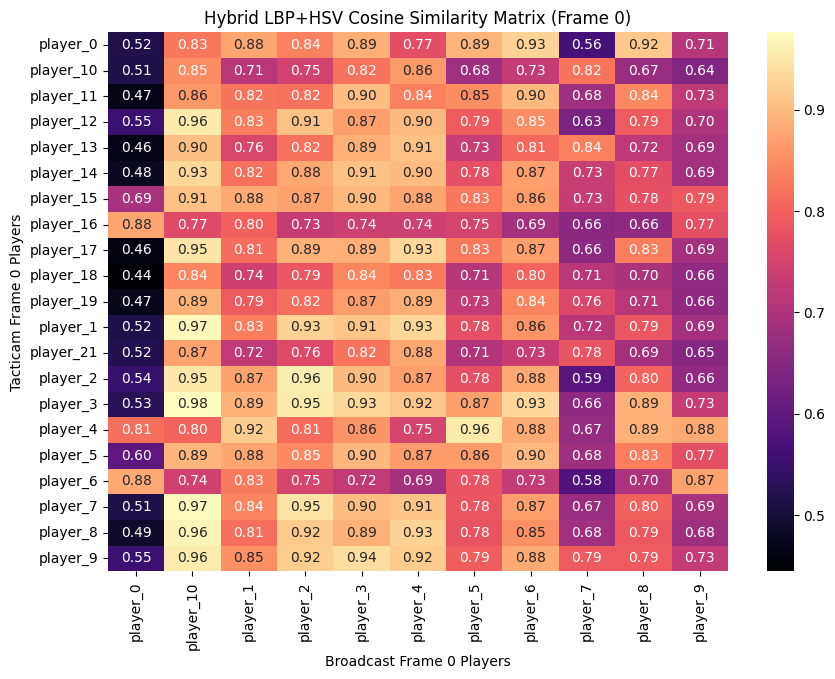

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def load_histograms(frame_dir, hist_type):
    hists = []
    names = []
    for file in sorted(os.listdir(frame_dir)):
        if file.endswith(hist_type):
            path = os.path.join(frame_dir, file)
            hist = np.load(path)
            hists.append(hist)
            names.append(file.replace(hist_type, ""))
    return hists, names

frame_dir_tacticam = "saved_LBP_HSV_tacticam/frame_0"
frame_dir_broadcast = "saved_LBP_HSV_broadcast/frame_0"

# Load both LBP and HSV histograms
lbp_tac, names_tac = load_histograms(frame_dir_tacticam, "_lbp.npy")
hsv_tac, _ = load_histograms(frame_dir_tacticam, "_hsv.npy")
lbp_brd, names_brd = load_histograms(frame_dir_broadcast, "_lbp.npy")
hsv_brd, _ = load_histograms(frame_dir_broadcast, "_hsv.npy")

# Combine (concatenate) LBP and HSV for each player
def combine_features(lbp_list, hsv_list):
    combined = []
    for lbp, hsv in zip(lbp_list, hsv_list):
        lbp_norm = lbp / (np.linalg.norm(lbp) + 1e-8)
        hsv_norm = hsv / (np.linalg.norm(hsv) + 1e-8)
        combined.append(np.concatenate([lbp_norm, hsv_norm]))
    return combined

combined_tac = combine_features(lbp_tac, hsv_tac)
combined_brd = combine_features(lbp_brd, hsv_brd)

# Compute confusion matrix using cosine similarity
if combined_tac and combined_brd:
    X = np.stack(combined_tac)
    Y = np.stack(combined_brd)
    sim_matrix = cosine_similarity(X, Y)
else:
    sim_matrix = np.zeros((len(combined_tac), len(combined_brd)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap="magma",
            xticklabels=names_brd, yticklabels=names_tac)
plt.xlabel("Broadcast Frame 0 Players")
plt.ylabel("Tacticam Frame 0 Players")
plt.title("Hybrid LBP+HSV Cosine Similarity Matrix (Frame 0)")

# IMPLEMENTING MAPPING PIELINE

In [21]:
# Cross-Camera Mapping Test Notebook: Tacticam <-> Broadcast (5 frames)
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# ---- CONFIG ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo_model = YOLO("model/best.pt")
from torchreid import models
transreid = models.build_model(
    name='osnet_ain_x1_0',
    num_classes=1000,
    pretrained=True
).to(device)
transreid.eval()
transform = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
lbp_radius = 5
lbp_n_points = 8 * lbp_radius
lbp_method = 'uniform'
max_frames = 5

def extract_features(frame, model, transreid, transform, device):
    result = model.predict(source=frame, conf=0.75, save=False, verbose=False)[0]
    players = []
    if result.boxes is not None:
        for i, box in enumerate(result.boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cls_id = int(box.cls[0].item())
            class_name = model.names[cls_id]
            if class_name.lower() != "player":
                continue
            crop = frame[y1:y2, x1:x2]
            # TransReID embedding
            crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            input_tensor = transform(crop_pil).unsqueeze(0).to(device)
            emb = transreid(input_tensor)
            emb = F.normalize(emb, p=2, dim=1).detach().cpu().numpy().flatten()
            # LBP
            gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            lbp = local_binary_pattern(gray_crop, lbp_n_points, lbp_radius, lbp_method)
            (lbp_hist, _) = np.histogram(lbp.ravel(),
                                         bins=np.arange(0, lbp_n_points + 3),
                                         range=(0, lbp_n_points + 2))
            lbp_hist = lbp_hist.astype("float")
            lbp_hist /= (lbp_hist.sum() + 1e-7)
            # HSV
            hsv_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
            hsv_hist = cv2.calcHist([hsv_crop], [0, 1, 2], None, [8, 8, 8],
                                    [0, 180, 0, 256, 0, 256])
            hsv_hist = cv2.normalize(hsv_hist, hsv_hist).flatten()
            # Hybrid feature
            lbp_norm = lbp_hist / (np.linalg.norm(lbp_hist) + 1e-8)
            hsv_norm = hsv_hist / (np.linalg.norm(hsv_hist) + 1e-8)
            hybrid = np.concatenate([lbp_norm, hsv_norm])
            players.append({
                "crop": crop,
                "embedding": emb,
                "hybrid": hybrid,
                "box": (x1, y1, x2, y2),
                "id": i
            })
    return players

# ---- Main Loop for 5 frames ----
tacticam_path = "dataset/tacticam.mp4"
broadcast_path = "dataset/broadcast.mp4"
output_dir = "output_cross_camera_mapping"
os.makedirs(output_dir, exist_ok=True)
cap_tac = cv2.VideoCapture(tacticam_path)
cap_brd = cv2.VideoCapture(broadcast_path)

for frame_idx in range(max_frames):
    ret_tac, frame_tac = cap_tac.read()
    ret_brd, frame_brd = cap_brd.read()
    if not ret_tac or not ret_brd:
        print("End of video(s).")
        break

    players_tac = extract_features(frame_tac, yolo_model, transreid, transform, device)
    players_brd = extract_features(frame_brd, yolo_model, transreid, transform, device)

    # Prepare hybrid features for similarity
    tac_hybrids = [p["hybrid"] for p in players_tac]
    brd_hybrids = [p["hybrid"] for p in players_brd]
    tac_ids = [str(p['id']) for p in players_tac]
    brd_ids = [str(p['id']) for p in players_brd]

    if tac_hybrids and brd_hybrids:
        X = np.stack(tac_hybrids)
        Y = np.stack(brd_hybrids)
        sim_matrix = cosine_similarity(X, Y)
    else:
        sim_matrix = np.zeros((len(tac_hybrids), len(brd_hybrids)))

    # Mapping: for each tacticam player, find best match in broadcast
    mapping = np.argmax(sim_matrix, axis=1) if sim_matrix.size else []

    # ---- Visualization ----
    # 1. Show confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap="magma",
                xticklabels=brd_ids, yticklabels=tac_ids)
    plt.xlabel("Broadcast Players")
    plt.ylabel("Tacticam Players")
    plt.title(f"Hybrid LBP+HSV Cosine Similarity (Frame {frame_idx})")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"confusion_matrix_frame_{frame_idx}.png"))
    plt.close()

    # 2. Show mapping visually on images
    vis_tac = frame_tac.copy()
    vis_brd = frame_brd.copy()
    for i, p in enumerate(players_tac):
        x1, y1, x2, y2 = p["box"]
        cv2.rectangle(vis_tac, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue for tacticam
        cv2.putText(vis_tac, f"{p['id']}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
        if len(mapping) > i and len(players_brd) > mapping[i]:
            brd_p = players_brd[mapping[i]]
            bx1, by1, bx2, by2 = brd_p["box"]
            cv2.rectangle(vis_brd, (bx1, by1), (bx2, by2), (0, 255, 255), 2)  # Yellow for broadcast
            cv2.putText(vis_brd, f"{p['id']}", (bx1, by1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2)

    # Save annotated images separately (not side by side)
    tac_save_path = os.path.join(output_dir, f"tacticam_mapped_frame_{frame_idx}.png")
    brd_save_path = os.path.join(output_dir, f"broadcast_mapped_frame_{frame_idx}.png")
    cv2.imwrite(tac_save_path, vis_tac)
    cv2.imwrite(brd_save_path, vis_brd)

cap_tac.release()
cap_brd.release()
print(f"All output frames and confusion matrices saved in '{output_dir}'")

Successfully loaded imagenet pretrained weights from "/Users/vivek/.cache/torch/checkpoints/osnet_ain_x1_0_imagenet.pth"
All output frames and confusion matrices saved in 'output_cross_camera_mapping'


### inconsisted mapping because of the false positive, forced assignment , solving this using similiarty threshold and hungarian algorithm

In [24]:
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment  # Hungarian algorithm

# ---- CONFIG ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo_model = YOLO("model/best.pt")
from torchreid import models
transreid = models.build_model(
    name='osnet_ain_x1_0',
    num_classes=1000,
    pretrained=True
).to(device)
transreid.eval()
transform = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
lbp_radius = 5
lbp_n_points = 8 * lbp_radius
lbp_method = 'uniform'
max_frames = 5

# Hybrid similarity threshold (tune as needed)
SIM_THRESHOLD = 0.75

def extract_features(frame, model, transreid, transform, device):
    result = model.predict(source=frame, conf=0.75, save=False, verbose=False)[0]
    players = []
    if result.boxes is not None:
        for i, box in enumerate(result.boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cls_id = int(box.cls[0].item())
            class_name = model.names[cls_id]
            if class_name.lower() != "player":
                continue
            crop = frame[y1:y2, x1:x2]
            # TransReID embedding
            crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            input_tensor = transform(crop_pil).unsqueeze(0).to(device)
            emb = transreid(input_tensor)
            emb = F.normalize(emb, p=2, dim=1).detach().cpu().numpy().flatten()
            # LBP
            gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            lbp = local_binary_pattern(gray_crop, lbp_n_points, lbp_radius, lbp_method)
            (lbp_hist, _) = np.histogram(lbp.ravel(),
                                         bins=np.arange(0, lbp_n_points + 3),
                                         range=(0, lbp_n_points + 2))
            lbp_hist = lbp_hist.astype("float")
            lbp_hist /= (lbp_hist.sum() + 1e-7)
            # HSV
            hsv_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
            hsv_hist = cv2.calcHist([hsv_crop], [0, 1, 2], None, [8, 8, 8],
                                    [0, 180, 0, 256, 0, 256])
            hsv_hist = cv2.normalize(hsv_hist, hsv_hist).flatten()
            # Hybrid feature
            lbp_norm = lbp_hist / (np.linalg.norm(lbp_hist) + 1e-8)
            hsv_norm = hsv_hist / (np.linalg.norm(hsv_hist) + 1e-8)
            hybrid = np.concatenate([lbp_norm, hsv_norm])
            players.append({
                "crop": crop,
                "embedding": emb,
                "hybrid": hybrid,
                "box": (x1, y1, x2, y2),
                "id": i
            })
    return players

# ---- Main Loop for 5 frames ----
tacticam_path = "dataset/tacticam.mp4"
broadcast_path = "dataset/broadcast.mp4"
output_dir = "output_cross_camera_mapping"
os.makedirs(output_dir, exist_ok=True)
cap_tac = cv2.VideoCapture(tacticam_path)
cap_brd = cv2.VideoCapture(broadcast_path)

for frame_idx in range(max_frames):
    ret_tac, frame_tac = cap_tac.read()
    ret_brd, frame_brd = cap_brd.read()
    if not ret_tac or not ret_brd:
        print("End of video(s).")
        break

    players_tac = extract_features(frame_tac, yolo_model, transreid, transform, device)
    players_brd = extract_features(frame_brd, yolo_model, transreid, transform, device)

    tac_hybrids = [p["hybrid"] for p in players_tac]
    brd_hybrids = [p["hybrid"] for p in players_brd]
    tac_ids = [str(p['id']) for p in players_tac]
    brd_ids = [str(p['id']) for p in players_brd]

    if tac_hybrids and brd_hybrids:
        X = np.stack(tac_hybrids)
        Y = np.stack(brd_hybrids)
        sim_matrix = cosine_similarity(X, Y)
    else:
        sim_matrix = np.zeros((len(tac_hybrids), len(brd_hybrids)))

    # ---- Hungarian Algorithm with Threshold ----
    # Convert similarity to cost (higher similarity = lower cost)
    cost_matrix = 1 - sim_matrix  # cosine similarity in [0,1]
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    # Build mapping with threshold
    mapping = [None] * len(players_tac)
    for i, j in zip(row_ind, col_ind):
        if sim_matrix[i, j] >= SIM_THRESHOLD:
            mapping[i] = j  # player i in tacticam mapped to player j in broadcast
        else:
            mapping[i] = None  # No match

    # ---- Visualization ----
    # 1. Show confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap="magma",
                xticklabels=brd_ids, yticklabels=tac_ids)
    plt.xlabel("Broadcast Players")
    plt.ylabel("Tacticam Players")
    plt.title(f"Hybrid LBP+HSV Cosine Similarity (Frame {frame_idx})")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"confusion_matrix_frame_{frame_idx}.png"))
    plt.close()

    # 2. Show mapping visually on images
    vis_tac = frame_tac.copy()
    vis_brd = frame_brd.copy()
    for i, p in enumerate(players_tac):
        x1, y1, x2, y2 = p["box"]
        cv2.rectangle(vis_tac, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue for tacticam
        cv2.putText(vis_tac, f"{p['id']}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
        if mapping[i] is not None and mapping[i] < len(players_brd):
            brd_p = players_brd[mapping[i]]
            bx1, by1, bx2, by2 = brd_p["box"]
            cv2.rectangle(vis_brd, (bx1, by1), (bx2, by2), (0, 255, 255), 2)  # Yellow for broadcast
            cv2.putText(vis_brd, f"{p['id']}", (bx1, by1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2)

    # Save annotated images separately (not side by side)
    tac_save_path = os.path.join(output_dir, f"tacticam_mapped_frame_{frame_idx}.png")
    brd_save_path = os.path.join(output_dir, f"broadcast_mapped_frame_{frame_idx}.png")
    cv2.imwrite(tac_save_path, vis_tac)
    cv2.imwrite(brd_save_path, vis_brd)

cap_tac.release()
cap_brd.release()
print(f"All output frames and confusion matrices saved in '{output_dir}'")

Successfully loaded imagenet pretrained weights from "/Users/vivek/.cache/torch/checkpoints/osnet_ain_x1_0_imagenet.pth"
All output frames and confusion matrices saved in 'output_cross_camera_mapping'


### the mapping are slightly better but not that good, it has few false prediction, but better than previous

### from the given algorithm , we observe that the players are getting false detection because of the jursey and the cloths they are wearing, causing the similairty to not generalise very well because of the cloths and very small feature maps,

### using a hybrid of temporal and trackable features 

In [27]:
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment  # Hungarian algorithm

# ---- CONFIG ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo_model = YOLO("model/best.pt")
from torchreid import models
transreid = models.build_model(
    name='osnet_ain_x1_0',
    num_classes=1000,
    pretrained=True
).to(device)
transreid.eval()
transform = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
lbp_radius = 5
lbp_n_points = 8 * lbp_radius
lbp_method = 'uniform'
max_frames = 5

# Hybrid similarity threshold (tune as needed)
SIM_THRESHOLD = 0.5

def extract_hybrid_features(frame, model, transreid, transform, device):
    result = model.predict(source=frame, conf=0.75, save=False, verbose=False)[0]
    players = []
    if result.boxes is not None:
        for i, box in enumerate(result.boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cls_id = int(box.cls[0].item())
            class_name = model.names[cls_id]
            if class_name.lower() != "player":
                continue
            crop = frame[y1:y2, x1:x2]
            # TransReID embedding
            crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            input_tensor = transform(crop_pil).unsqueeze(0).to(device)
            emb = transreid(input_tensor)
            emb = F.normalize(emb, p=2, dim=1).detach().cpu().numpy().flatten()
            # LBP
            gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            lbp = local_binary_pattern(gray_crop, lbp_n_points, lbp_radius, lbp_method)
            (lbp_hist, _) = np.histogram(lbp.ravel(),
                                         bins=np.arange(0, lbp_n_points + 3),
                                         range=(0, lbp_n_points + 2))
            lbp_hist = lbp_hist.astype("float")
            lbp_hist /= (lbp_hist.sum() + 1e-7)
            # HSV
            hsv_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
            hsv_hist = cv2.calcHist([hsv_crop], [0, 1, 2], None, [8, 8, 8],
                                    [0, 180, 0, 256, 0, 256])
            hsv_hist = cv2.normalize(hsv_hist, hsv_hist).flatten()
            # Hybrid feature: concatenate normalized LBP, HSV, and TransReID embedding
            lbp_norm = lbp_hist / (np.linalg.norm(lbp_hist) + 1e-8)
            hsv_norm = hsv_hist / (np.linalg.norm(hsv_hist) + 1e-8)
            emb_norm = emb / (np.linalg.norm(emb) + 1e-8)
            hybrid = np.concatenate([lbp_norm, hsv_norm, emb_norm])
            players.append({
                "crop": crop,
                "embedding": emb,
                "hybrid": hybrid,
                "box": (x1, y1, x2, y2),
                "id": i
            })
    return players

# ---- Main Loop for 5 frames ----
tacticam_path = "dataset/tacticam.mp4"
broadcast_path = "dataset/broadcast.mp4"
output_dir = "output_cross_camera_mapping_hybrid"
os.makedirs(output_dir, exist_ok=True)
cap_tac = cv2.VideoCapture(tacticam_path)
cap_brd = cv2.VideoCapture(broadcast_path)

for frame_idx in range(max_frames):
    ret_tac, frame_tac = cap_tac.read()
    ret_brd, frame_brd = cap_brd.read()
    if not ret_tac or not ret_brd:
        print("End of video(s).")
        break

    players_tac = extract_hybrid_features(frame_tac, yolo_model, transreid, transform, device)
    players_brd = extract_hybrid_features(frame_brd, yolo_model, transreid, transform, device)

    tac_hybrids = [p["hybrid"] for p in players_tac]
    brd_hybrids = [p["hybrid"] for p in players_brd]
    tac_ids = [str(p['id']) for p in players_tac]
    brd_ids = [str(p['id']) for p in players_brd]

    if tac_hybrids and brd_hybrids:
        X = np.stack(tac_hybrids)
        Y = np.stack(brd_hybrids)
        sim_matrix = cosine_similarity(X, Y)
    else:
        sim_matrix = np.zeros((len(tac_hybrids), len(brd_hybrids)))

    # ---- Hungarian Algorithm with Similarity Threshold ----
    cost_matrix = 1 - sim_matrix  # higher similarity = lower cost
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    mapping = [None] * len(players_tac)
    for i, j in zip(row_ind, col_ind):
        if sim_matrix[i, j] >= SIM_THRESHOLD:
            mapping[i] = j
        else:
            mapping[i] = None

    # ---- Visualization ----
    # 1. Save confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap="magma",
                xticklabels=brd_ids, yticklabels=tac_ids)
    plt.xlabel("Broadcast Players")
    plt.ylabel("Tacticam Players")
    plt.title(f"Hybrid (LBP+HSV+TransReID) Cosine Similarity (Frame {frame_idx})")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"confusion_matrix_frame_{frame_idx}.png"))
    plt.close()

    # 2. Save mapping visualization for each frame
    vis_tac = frame_tac.copy()
    vis_brd = frame_brd.copy()
    for i, p in enumerate(players_tac):
        x1, y1, x2, y2 = p["box"]
        cv2.rectangle(vis_tac, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue for tacticam
        cv2.putText(vis_tac, f"{p['id']}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
        if mapping[i] is not None and mapping[i] < len(players_brd):
            brd_p = players_brd[mapping[i]]
            bx1, by1, bx2, by2 = brd_p["box"]
            cv2.rectangle(vis_brd, (bx1, by1), (bx2, by2), (0, 255, 255), 2)  # Yellow for broadcast
            cv2.putText(vis_brd, f"{p['id']}", (bx1, by1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2)

    tac_save_path = os.path.join(output_dir, f"tacticam_mapped_frame_{frame_idx}.png")
    brd_save_path = os.path.join(output_dir, f"broadcast_mapped_frame_{frame_idx}.png")
    cv2.imwrite(tac_save_path, vis_tac)
    cv2.imwrite(brd_save_path, vis_brd)

cap_tac.release()
cap_brd.release()
print(f"All output frames and confusion matrices saved")

Successfully loaded imagenet pretrained weights from "/Users/vivek/.cache/torch/checkpoints/osnet_ain_x1_0_imagenet.pth"
All output frames and confusion matrices saved


### the false prediction have reduced and the algo works much better now

## taking more hybrid features for feature extraction 

### 1)use multipele reid, 2)include a region around player for relative context, 3) taking mulitple frame for feature extractoion

### inproving the   similairty search

### 1) using re-ranking in case of faliure 

In [28]:
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment  # Hungarian algorithm

# For re-ranking
try:
    from re_ranking import re_ranking  # pip install re-ranking (https://github.com/layumi/Person_reID_Re-Ranking)
except ImportError:
    def re_ranking(q_g_dist, q_q_dist, g_g_dist, k1=20, k2=6, lambda_value=0.3):
        # fallback: just return original distance
        return q_g_dist

# ---- CONFIG ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo_model = YOLO("model/best.pt")
from torchreid import models
# Ensemble: OSNet + ResNet50
osnet = models.build_model(
    name='osnet_ain_x1_0',
    num_classes=1000,
    pretrained=True
).to(device)
osnet.eval()
resnet = models.build_model(
    name='resnet50',
    num_classes=1000,
    pretrained=True
).to(device)
resnet.eval()
transform = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
lbp_radius = 5
lbp_n_points = 8 * lbp_radius
lbp_method = 'uniform'
max_frames = 5
context_ratio = 0.15  # 15% context around the box
temporal_window = 3   # Number of frames for temporal aggregation
SIM_THRESHOLD = 0.5   # Similarity threshold for "no match"

# ---- Temporal Buffer for Each Camera ----
temporal_buffer_tac = {}
temporal_buffer_brd = {}

def get_context_box(x1, y1, x2, y2, img_shape, ratio=0.15):
    h, w = img_shape[:2]
    dx = int((x2 - x1) * ratio)
    dy = int((y2 - y1) * ratio)
    nx1 = max(0, x1 - dx)
    ny1 = max(0, y1 - dy)
    nx2 = min(w, x2 + dx)
    ny2 = min(h, y2 + dy)
    return nx1, ny1, nx2, ny2

def extract_ensemble_embedding(crop_pil):
    # OSNet
    input_tensor = transform(crop_pil).unsqueeze(0).to(device)
    emb_osnet = osnet(input_tensor)
    emb_osnet = F.normalize(emb_osnet, p=2, dim=1).detach().cpu().numpy().flatten()
    # ResNet
    emb_resnet = resnet(input_tensor)
    emb_resnet = F.normalize(emb_resnet, p=2, dim=1).detach().cpu().numpy().flatten()
    # Concatenate
    emb = np.concatenate([emb_osnet, emb_resnet])
    emb = emb / (np.linalg.norm(emb) + 1e-8)
    return emb

def extract_hybrid_features(frame, model, device, temporal_buffer, frame_idx, cam_name):
    result = model.predict(source=frame, conf=0.75, save=False, verbose=False)[0]
    players = []
    if result.boxes is not None:
        for i, box in enumerate(result.boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cls_id = int(box.cls[0].item())
            class_name = model.names[cls_id]
            if class_name.lower() != "player":
                continue
            # Context crop
            cx1, cy1, cx2, cy2 = get_context_box(x1, y1, x2, y2, frame.shape, context_ratio)
            crop = frame[cy1:cy2, cx1:cx2]
            crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            # Ensemble embedding
            emb = extract_ensemble_embedding(crop_pil)
            # LBP
            gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            lbp = local_binary_pattern(gray_crop, lbp_n_points, lbp_radius, lbp_method)
            (lbp_hist, _) = np.histogram(lbp.ravel(),
                                         bins=np.arange(0, lbp_n_points + 3),
                                         range=(0, lbp_n_points + 2))
            lbp_hist = lbp_hist.astype("float")
            lbp_hist /= (lbp_hist.sum() + 1e-7)
            # HSV
            hsv_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
            hsv_hist = cv2.calcHist([hsv_crop], [0, 1, 2], None, [8, 8, 8],
                                    [0, 180, 0, 256, 0, 256])
            hsv_hist = cv2.normalize(hsv_hist, hsv_hist).flatten()
            # Hybrid feature: concatenate normalized LBP, HSV, and ensemble embedding
            lbp_norm = lbp_hist / (np.linalg.norm(lbp_hist) + 1e-8)
            hsv_norm = hsv_hist / (np.linalg.norm(hsv_hist) + 1e-8)
            emb_norm = emb / (np.linalg.norm(emb) + 1e-8)
            hybrid = np.concatenate([lbp_norm, hsv_norm, emb_norm])
            # Temporal aggregation
            pid = f"{cam_name}_{i}"
            if pid not in temporal_buffer:
                temporal_buffer[pid] = []
            temporal_buffer[pid].append(hybrid)
            # Keep only last N frames
            if len(temporal_buffer[pid]) > temporal_window:
                temporal_buffer[pid] = temporal_buffer[pid][-temporal_window:]
            # Aggregate (mean)
            hybrid_temporal = np.mean(temporal_buffer[pid], axis=0)
            players.append({
                "crop": crop,
                "embedding": emb,
                "hybrid": hybrid_temporal,
                "box": (x1, y1, x2, y2),
                "id": i,
                "pid": pid
            })
    return players

# ---- Main Loop for 5 frames ----
tacticam_path = "dataset/tacticam.mp4"
broadcast_path = "dataset/broadcast.mp4"
output_dir = "output_cross_camera_mapping_ensemble_temporal"
os.makedirs(output_dir, exist_ok=True)
cap_tac = cv2.VideoCapture(tacticam_path)
cap_brd = cv2.VideoCapture(broadcast_path)

for frame_idx in range(max_frames):
    ret_tac, frame_tac = cap_tac.read()
    ret_brd, frame_brd = cap_brd.read()
    if not ret_tac or not ret_brd:
        print("End of video(s).")
        break

    players_tac = extract_hybrid_features(frame_tac, yolo_model, device, temporal_buffer_tac, frame_idx, "tac")
    players_brd = extract_hybrid_features(frame_brd, yolo_model, device, temporal_buffer_brd, frame_idx, "brd")

    tac_hybrids = [p["hybrid"] for p in players_tac]
    brd_hybrids = [p["hybrid"] for p in players_brd]
    tac_ids = [str(p['id']) for p in players_tac]
    brd_ids = [str(p['id']) for p in players_brd]

    if tac_hybrids and brd_hybrids:
        X = np.stack(tac_hybrids)
        Y = np.stack(brd_hybrids)
        # Initial cosine similarity
        sim_matrix = cosine_similarity(X, Y)
        # Re-ranking (k-reciprocal)
        q_g_dist = 1 - sim_matrix
        q_q_dist = 1 - cosine_similarity(X, X)
        g_g_dist = 1 - cosine_similarity(Y, Y)
        rerank_dist = re_ranking(q_g_dist, q_q_dist, g_g_dist)
        sim_matrix = 1 - rerank_dist  # Convert back to similarity
    else:
        sim_matrix = np.zeros((len(tac_hybrids), len(brd_hybrids)))

    # ---- Hungarian Algorithm with Similarity Threshold and "No Match" Option ----
    cost_matrix = 1 - sim_matrix  # higher similarity = lower cost
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    mapping = [None] * len(players_tac)
    for i, j in zip(row_ind, col_ind):
        if sim_matrix[i, j] >= SIM_THRESHOLD:
            mapping[i] = j
        else:
            mapping[i] = None  # No match if below threshold

    # ---- Visualization ----
    # 1. Save confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap="magma",
                xticklabels=brd_ids, yticklabels=tac_ids)
    plt.xlabel("Broadcast Players")
    plt.ylabel("Tacticam Players")
    plt.title(f"Ensemble+Context+Temporal+ReRank Similarity (Frame {frame_idx})")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"confusion_matrix_frame_{frame_idx}.png"))
    plt.close()

    # 2. Save mapping visualization for each frame
    vis_tac = frame_tac.copy()
    vis_brd = frame_brd.copy()
    for i, p in enumerate(players_tac):
        x1, y1, x2, y2 = p["box"]
        cv2.rectangle(vis_tac, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue for tacticam
        cv2.putText(vis_tac, f"{p['id']}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
        if mapping[i] is not None and mapping[i] < len(players_brd):
            brd_p = players_brd[mapping[i]]
            bx1, by1, bx2, by2 = brd_p["box"]
            cv2.rectangle(vis_brd, (bx1, by1), (bx2, by2), (0, 255, 255), 2)  # Yellow for broadcast
            cv2.putText(vis_brd, f"{p['id']}", (bx1, by1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2)
        else:
            # No match: mark in red on tacticam
            cv2.rectangle(vis_tac, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(vis_tac, f"NO MATCH", (x1, y2+20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    tac_save_path = os.path.join(output_dir, f"tacticam_mapped_frame_{frame_idx}.png")
    brd_save_path = os.path.join(output_dir, f"broadcast_mapped_frame_{frame_idx}.png")
    cv2.imwrite(tac_save_path, vis_tac)
    cv2.imwrite(brd_save_path, vis_brd)

cap_tac.release()
cap_brd.release()
print(f"All output frames and confusion matrices saved in '{output_dir}'")

Successfully loaded imagenet pretrained weights from "/Users/vivek/.cache/torch/checkpoints/osnet_ain_x1_0_imagenet.pth"
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/vivek/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


100%|██████████| 97.8M/97.8M [01:49<00:00, 937kB/s] 


All output frames and confusion matrices saved in 'output_cross_camera_mapping_ensemble_temporal'


### the performance has droped in abvoe code

### taking the code above this code and inproving base on this: 1) better feature extractio nusing multiple reid, include a refion around player
### we have osnet with 0.7 and resnet with 0.3 weitage

In [31]:
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment  # Hungarian algorithm

# ---- CONFIG ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo_model = YOLO("model/best.pt")
from torchreid import models
# Load both OSNet and ResNet50 for ensemble
osnet = models.build_model(
    name='osnet_ain_x1_0',
    num_classes=1000,
    pretrained=True
).to(device)
osnet.eval()
resnet = models.build_model(
    name='resnet50',
    num_classes=1000,
    pretrained=True
).to(device)
resnet.eval()
transform = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
lbp_radius = 5
lbp_n_points = 8 * lbp_radius
lbp_method = 'uniform'
max_frames = 5
context_ratio = 0.15  # 15% context around the box
SIM_THRESHOLD = 0.5

def get_context_box(x1, y1, x2, y2, img_shape, ratio=0.15):
    h, w = img_shape[:2]
    dx = int((x2 - x1) * ratio)
    dy = int((y2 - y1) * ratio)
    nx1 = max(0, x1 - dx)
    ny1 = max(0, y1 - dy)
    nx2 = min(w, x2 + dx)
    ny2 = min(h, y2 + dy)
    return nx1, ny1, nx2, ny2

# def extract_ensemble_embedding(crop_pil):
#     input_tensor = transform(crop_pil).unsqueeze(0).to(device)
#     emb_osnet = osnet(input_tensor)
#     emb_osnet = F.normalize(emb_osnet, p=2, dim=1).detach().cpu().numpy().flatten()
#     emb_resnet = resnet(input_tensor)
#     emb_resnet = F.normalize(emb_resnet, p=2, dim=1).detach().cpu().numpy().flatten()
#     # Weighted sum: 0.7 OSNet, 0.3 ResNet50
#     emb = 0.7 * emb_osnet + 0.3 * emb_resnet
#     emb = emb / (np.linalg.norm(emb) + 1e-8)
#     return emb
def extract_ensemble_embedding(crop_pil):
    input_tensor = transform(crop_pil).unsqueeze(0).to(device)
    emb_osnet = osnet(input_tensor)
    emb_osnet = F.normalize(emb_osnet, p=2, dim=1).detach().cpu().numpy().flatten()
    emb_resnet = resnet(input_tensor)
    emb_resnet = F.normalize(emb_resnet, p=2, dim=1).detach().cpu().numpy().flatten()
    # Concatenate and normalize
    emb = np.concatenate([0.7 * emb_osnet, 0.3 * emb_resnet])
    emb = emb / (np.linalg.norm(emb) + 1e-8)
    return emb

# Temporal buffer for each camera
temporal_window = 3
temporal_buffer_tac = {}
temporal_buffer_brd = {}

def extract_hybrid_features(frame, model, device, temporal_buffer, frame_idx, cam_name):
    result = model.predict(source=frame, conf=0.75, save=False, verbose=False)[0]
    players = []
    if result.boxes is not None:
        for i, box in enumerate(result.boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cls_id = int(box.cls[0].item())
            class_name = model.names[cls_id]
            if class_name.lower() != "player":
                continue
            # Context crop
            cx1, cy1, cx2, cy2 = get_context_box(x1, y1, x2, y2, frame.shape, context_ratio)
            crop = frame[cy1:cy2, cx1:cx2]
            crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            # Ensemble embedding
            emb = extract_ensemble_embedding(crop_pil)
            # LBP
            gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            lbp = local_binary_pattern(gray_crop, lbp_n_points, lbp_radius, lbp_method)
            (lbp_hist, _) = np.histogram(lbp.ravel(),
                                         bins=np.arange(0, lbp_n_points + 3),
                                         range=(0, lbp_n_points + 2))
            lbp_hist = lbp_hist.astype("float")
            lbp_hist /= (lbp_hist.sum() + 1e-7)
            # HSV
            hsv_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
            hsv_hist = cv2.calcHist([hsv_crop], [0, 1, 2], None, [8, 8, 8],
                                    [0, 180, 0, 256, 0, 256])
            hsv_hist = cv2.normalize(hsv_hist, hsv_hist).flatten()
            # Hybrid feature: concatenate normalized LBP, HSV, and ensemble embedding
            lbp_norm = lbp_hist / (np.linalg.norm(lbp_hist) + 1e-8)
            hsv_norm = hsv_hist / (np.linalg.norm(hsv_hist) + 1e-8)
            emb_norm = emb / (np.linalg.norm(emb) + 1e-8)
            hybrid = np.concatenate([lbp_norm, hsv_norm, emb_norm])
            # Temporal aggregation
            pid = f"{cam_name}_{i}"
            if pid not in temporal_buffer:
                temporal_buffer[pid] = []
            temporal_buffer[pid].append(hybrid)
            if len(temporal_buffer[pid]) > temporal_window:
                temporal_buffer[pid] = temporal_buffer[pid][-temporal_window:]
            hybrid_temporal = np.mean(temporal_buffer[pid], axis=0)
            players.append({
                "crop": crop,
                "embedding": emb,
                "hybrid": hybrid_temporal,
                "box": (x1, y1, x2, y2),
                "id": i,
                "pid": pid
            })
    return players

# ---- Main Loop for 5 frames ----
tacticam_path = "dataset/tacticam.mp4"
broadcast_path = "dataset/broadcast.mp4"
output_dir = "output_cross_camera_mapping_hybrid_ensemble_osnet_0_7_resnet_0_3"
os.makedirs(output_dir, exist_ok=True)
cap_tac = cv2.VideoCapture(tacticam_path)
cap_brd = cv2.VideoCapture(broadcast_path)

for frame_idx in range(max_frames):
    ret_tac, frame_tac = cap_tac.read()
    ret_brd, frame_brd = cap_brd.read()
    if not ret_tac or not ret_brd:
        print("End of video(s).")
        break

    players_tac = extract_hybrid_features(frame_tac, yolo_model, device, temporal_buffer_tac, frame_idx, "tac")
    players_brd = extract_hybrid_features(frame_brd, yolo_model, device, temporal_buffer_brd, frame_idx, "brd")

    tac_hybrids = [p["hybrid"] for p in players_tac]
    brd_hybrids = [p["hybrid"] for p in players_brd]
    tac_ids = [str(p['id']) for p in players_tac]
    brd_ids = [str(p['id']) for p in players_brd]

    if tac_hybrids and brd_hybrids:
        X = np.stack(tac_hybrids)
        Y = np.stack(brd_hybrids)
        sim_matrix = cosine_similarity(X, Y)
    else:
        sim_matrix = np.zeros((len(tac_hybrids), len(brd_hybrids)))

    # ---- Hungarian Algorithm with Similarity Threshold ----
    cost_matrix = 1 - sim_matrix  # higher similarity = lower cost
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    mapping = [None] * len(players_tac)
    for i, j in zip(row_ind, col_ind):
        if sim_matrix[i, j] >= SIM_THRESHOLD:
            mapping[i] = j
        else:
            mapping[i] = None

    # ---- Visualization ----
    # 1. Save confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap="magma",
                xticklabels=brd_ids, yticklabels=tac_ids)
    plt.xlabel("Broadcast Players")
    plt.ylabel("Tacticam Players")
    plt.title(f"Hybrid (LBP+HSV+OSNet+ResNet50) Cosine Similarity (Frame {frame_idx})")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"confusion_matrix_frame_{frame_idx}.png"))
    plt.close()

    # 2. Save mapping visualization for each frame
    vis_tac = frame_tac.copy()
    vis_brd = frame_brd.copy()
    for i, p in enumerate(players_tac):
        x1, y1, x2, y2 = p["box"]
        cv2.rectangle(vis_tac, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue for tacticam
        cv2.putText(vis_tac, f"{p['id']}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
        if mapping[i] is not None and mapping[i] < len(players_brd):
            brd_p = players_brd[mapping[i]]
            bx1, by1, bx2, by2 = brd_p["box"]
            cv2.rectangle(vis_brd, (bx1, by1), (bx2, by2), (0, 255, 255), 2)  # Yellow for broadcast
            cv2.putText(vis_brd, f"{p['id']}", (bx1, by1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2)
        else:
            # No match: mark in red on tacticam
            cv2.rectangle(vis_tac, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(vis_tac, f"NO MATCH", (x1, y2+20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    tac_save_path = os.path.join(output_dir, f"tacticam_mapped_frame_{frame_idx}.png")
    brd_save_path = os.path.join(output_dir, f"broadcast_mapped_frame_{frame_idx}.png")
    cv2.imwrite(tac_save_path, vis_tac)
    cv2.imwrite(brd_save_path, vis_brd)

cap_tac.release()
cap_brd.release()
print(f"All output frames and")

Successfully loaded imagenet pretrained weights from "/Users/vivek/.cache/torch/checkpoints/osnet_ain_x1_0_imagenet.pth"
All output frames and


### the performace is still poor for the above hybrid feature extraction

## using resnet-IBM


In [41]:
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment  # Hungarian algorithm

# ---- CONFIG ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo_model = YOLO("model/best.pt")
from torchreid import models
# Load both OSNet and ResNet50-IBN-A for ensemble
osnet = models.build_model(
    name='osnet_ain_x1_0',
    num_classes=1000,
    pretrained=True
).to(device)
osnet.eval()
resnet_ibn = models.build_model(
    name='resnet50_ibn_a',
    num_classes=1000,
    pretrained=True
).to(device)
resnet_ibn.eval()
transform = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
lbp_radius = 5
lbp_n_points = 8 * lbp_radius
lbp_method = 'uniform'
max_frames = 5
context_ratio = 0.15  # 15% context around the box
SIM_THRESHOLD = 0.5

def get_context_box(x1, y1, x2, y2, img_shape, ratio=0.15):
    h, w = img_shape[:2]
    dx = int((x2 - x1) * ratio)
    dy = int((y2 - y1) * ratio)
    nx1 = max(0, x1 - dx)
    ny1 = max(0, y1 - dy)
    nx2 = min(w, x2 + dx)
    ny2 = min(h, y2 + dy)
    return nx1, ny1, nx2, ny2

def extract_ensemble_embedding(crop_pil):
    input_tensor = transform(crop_pil).unsqueeze(0).to(device)
    emb_osnet = osnet(input_tensor)
    emb_osnet = F.normalize(emb_osnet, p=2, dim=1).detach().cpu().numpy().flatten()
    emb_resnet_ibn = resnet_ibn(input_tensor)
    emb_resnet_ibn = F.normalize(emb_resnet_ibn, p=2, dim=1).detach().cpu().numpy().flatten()
    # Concatenate and normalize (0.7 OSNet, 0.3 ResNet-IBN)
    emb = np.concatenate([ emb_osnet,0.1* emb_resnet_ibn])
    emb = emb / (np.linalg.norm(emb) + 1e-8)
    return emb

# Temporal buffer for each camera
temporal_window = 3
temporal_buffer_tac = {}
temporal_buffer_brd = {}

def extract_hybrid_features(frame, model, device, temporal_buffer, frame_idx, cam_name):
    result = model.predict(source=frame, conf=0.75, save=False, verbose=False)[0]
    players = []
    if result.boxes is not None:
        for i, box in enumerate(result.boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cls_id = int(box.cls[0].item())
            class_name = model.names[cls_id]
            if class_name.lower() != "player":
                continue
            # Context crop
            cx1, cy1, cx2, cy2 = get_context_box(x1, y1, x2, y2, frame.shape, context_ratio)
            crop = frame[cy1:cy2, cx1:cx2]
            crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            # Ensemble embedding
            emb = extract_ensemble_embedding(crop_pil)
            # LBP
            gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            lbp = local_binary_pattern(gray_crop, lbp_n_points, lbp_radius, lbp_method)
            (lbp_hist, _) = np.histogram(lbp.ravel(),
                                         bins=np.arange(0, lbp_n_points + 3),
                                         range=(0, lbp_n_points + 2))
            lbp_hist = lbp_hist.astype("float")
            lbp_hist /= (lbp_hist.sum() + 1e-7)
            # HSV
            hsv_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
            hsv_hist = cv2.calcHist([hsv_crop], [0, 1, 2], None, [8, 8, 8],
                                    [0, 180, 0, 256, 0, 256])
            hsv_hist = cv2.normalize(hsv_hist, hsv_hist).flatten()
            # Hybrid feature: concatenate normalized LBP, HSV, and ensemble embedding
            lbp_norm = lbp_hist / (np.linalg.norm(lbp_hist) + 1e-8)
            hsv_norm = hsv_hist / (np.linalg.norm(hsv_hist) + 1e-8)
            emb_norm = emb / (np.linalg.norm(emb) + 1e-8)
            hybrid = np.concatenate([lbp_norm, hsv_norm, emb_norm])
            # Temporal aggregation
            pid = f"{cam_name}_{i}"
            if pid not in temporal_buffer:
                temporal_buffer[pid] = []
            temporal_buffer[pid].append(hybrid)
            if len(temporal_buffer[pid]) > temporal_window:
                temporal_buffer[pid] = temporal_buffer[pid][-temporal_window:]
            hybrid_temporal = np.mean(temporal_buffer[pid], axis=0)
            players.append({
                "crop": crop,
                "embedding": emb,
                "hybrid": hybrid_temporal,
                "box": (x1, y1, x2, y2),
                "id": i,
                "pid": pid
            })
    return players

# ---- Main Loop for 5 frames ----
tacticam_path = "dataset/tacticam.mp4"
broadcast_path = "dataset/broadcast.mp4"
output_dir = "output_cross_camera_mapping_hybrid_ensemble_osnet_ibn"
os.makedirs(output_dir, exist_ok=True)
cap_tac = cv2.VideoCapture(tacticam_path)
cap_brd = cv2.VideoCapture(broadcast_path)

for frame_idx in range(max_frames):
    ret_tac, frame_tac = cap_tac.read()
    ret_brd, frame_brd = cap_brd.read()
    if not ret_tac or not ret_brd:
        print("End of video(s).")
        break

    players_tac = extract_hybrid_features(frame_tac, yolo_model, device, temporal_buffer_tac, frame_idx, "tac")
    players_brd = extract_hybrid_features(frame_brd, yolo_model, device, temporal_buffer_brd, frame_idx, "brd")

    tac_hybrids = [p["hybrid"] for p in players_tac]
    brd_hybrids = [p["hybrid"] for p in players_brd]
    tac_ids = [str(p['id']) for p in players_tac]
    brd_ids = [str(p['id']) for p in players_brd]

    if tac_hybrids and brd_hybrids:
        X = np.stack(tac_hybrids)
        Y = np.stack(brd_hybrids)
        sim_matrix = cosine_similarity(X, Y)
    else:
        sim_matrix = np.zeros((len(tac_hybrids), len(brd_hybrids)))

    # ---- Hungarian Algorithm with Similarity Threshold ----
    cost_matrix = 1 - sim_matrix  # higher similarity = lower cost
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    mapping = [None] * len(players_tac)
    for i, j in zip(row_ind, col_ind):
        if sim_matrix[i, j] >= SIM_THRESHOLD:
            mapping[i] = j
        else:
            mapping[i] = None

    # ---- Visualization ----
    # 1. Save confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap="magma",
                xticklabels=brd_ids, yticklabels=tac_ids)
    plt.xlabel("Broadcast Players")
    plt.ylabel("Tacticam Players")
    plt.title(f"Hybrid (LBP+HSV+OSNet+ResNet50-IBN) Cosine Similarity (Frame {frame_idx})")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"confusion_matrix_frame_{frame_idx}.png"))
    plt.close()

    # 2. Save mapping visualization for each frame
    vis_tac = frame_tac.copy()
    vis_brd = frame_brd.copy()
    for i, p in enumerate(players_tac):
        x1, y1, x2, y2 = p["box"]
        cv2.rectangle(vis_tac, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue for tacticam
        cv2.putText(vis_tac, f"{p['id']}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
        if mapping[i] is not None and mapping[i] < len(players_brd):
            brd_p = players_brd[mapping[i]]
            bx1, by1, bx2, by2 = brd_p["box"]
            cv2.rectangle(vis_brd, (bx1, by1), (bx2, by2), (0, 255, 255), 2)  # Yellow for broadcast
            cv2.putText(vis_brd, f"{p['id']}", (bx1, by1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2)
        else:
            # No match: mark in red on tacticam
            cv2.rectangle(vis_tac, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(vis_tac, f"NO MATCH", (x1, y2+20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    tac_save_path = os.path.join(output_dir, f"tacticam_mapped_frame_{frame_idx}.png")
    brd_save_path = os.path.join(output_dir, f"broadcast_mapped_frame_{frame_idx}.png")
    cv2.imwrite(tac_save_path, vis_tac)
    cv2.imwrite(brd_save_path, vis_brd)

cap_tac.release()
cap_brd.release()
print(f"All output frames and confusion matrices saved in {output_dir} ")

Successfully loaded imagenet pretrained weights from "/Users/vivek/.cache/torch/checkpoints/osnet_ain_x1_0_imagenet.pth"
All output frames and confusion matrices saved in output_cross_camera_mapping_hybrid_ensemble_osnet_ibn 


### the output are not that good, using the same model twice one will take the same player and the other will take the same player with extra window for much better feature extractoin

In [43]:
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment  # Hungarian algorithm

# ---- CONFIG ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo_model = YOLO("model/best.pt")
from torchreid import models
osnet = models.build_model(
    name='osnet_ain_x1_0',
    num_classes=1000,
    pretrained=True
).to(device)
osnet.eval()
transform = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
lbp_radius = 5
lbp_n_points = 8 * lbp_radius
lbp_method = 'uniform'
max_frames = 5
context_ratio = 0.15  # 15% context around the box
SIM_THRESHOLD = 0.5

def get_context_box(x1, y1, x2, y2, img_shape, ratio=0.5):
    h, w = img_shape[:2]
    width = x2 - x1
    height = y2 - y1
    dx = int(width * ratio / 2)
    dy = int(height * ratio / 2)
    nx1 = max(0, x1 - dx)
    ny1 = max(0, y1 - dy)
    nx2 = min(w, x2 + dx)
    ny2 = min(h, y2 + dy)
    return nx1, ny1, nx2, ny2

def extract_osnet_mean_embedding(frame, x1, y1, x2, y2):
    # Player crop
    crop = frame[y1:y2, x1:x2]
    crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    input_tensor = transform(crop_pil).unsqueeze(0).to(device)
    emb1 = osnet(input_tensor)
    emb1 = F.normalize(emb1, p=2, dim=1).detach().cpu().numpy().flatten()
    # Context crop (0.5x more region in height and width)
    cx1, cy1, cx2, cy2 = get_context_box(x1, y1, x2, y2, frame.shape, ratio=0.5)
    context_crop = frame[cy1:cy2, cx1:cx2]
    context_pil = Image.fromarray(cv2.cvtColor(context_crop, cv2.COLOR_BGR2RGB))
    input_tensor_context = transform(context_pil).unsqueeze(0).to(device)
    emb2 = osnet(input_tensor_context)
    emb2 = F.normalize(emb2, p=2, dim=1).detach().cpu().numpy().flatten()
    # Mean embedding
    emb = (emb1 + emb2) / 2.0
    emb = emb / (np.linalg.norm(emb) + 1e-8)
    return emb

# Temporal buffer for each camera
temporal_window = 3
temporal_buffer_tac = {}
temporal_buffer_brd = {}

def extract_hybrid_features(frame, model, device, temporal_buffer, frame_idx, cam_name):
    result = model.predict(source=frame, conf=0.75, save=False, verbose=False)[0]
    players = []
    if result.boxes is not None:
        for i, box in enumerate(result.boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cls_id = int(box.cls[0].item())
            class_name = model.names[cls_id]
            if class_name.lower() != "player":
                continue
            # OSNet mean embedding (player + context)
            emb = extract_osnet_mean_embedding(frame, x1, y1, x2, y2)
            # LBP
            crop = frame[y1:y2, x1:x2]
            gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            lbp = local_binary_pattern(gray_crop, lbp_n_points, lbp_radius, lbp_method)
            (lbp_hist, _) = np.histogram(lbp.ravel(),
                                         bins=np.arange(0, lbp_n_points + 3),
                                         range=(0, lbp_n_points + 2))
            lbp_hist = lbp_hist.astype("float")
            lbp_hist /= (lbp_hist.sum() + 1e-7)
            # HSV
            hsv_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
            hsv_hist = cv2.calcHist([hsv_crop], [0, 1, 2], None, [8, 8, 8],
                                    [0, 180, 0, 256, 0, 256])
            hsv_hist = cv2.normalize(hsv_hist, hsv_hist).flatten()
            # Hybrid feature: concatenate normalized LBP, HSV, and embedding
            lbp_norm = lbp_hist / (np.linalg.norm(lbp_hist) + 1e-8)
            hsv_norm = hsv_hist / (np.linalg.norm(hsv_hist) + 1e-8)
            emb_norm = emb / (np.linalg.norm(emb) + 1e-8)
            hybrid = np.concatenate([lbp_norm, hsv_norm, emb_norm])
            # Temporal aggregation
            pid = f"{cam_name}_{i}"
            if pid not in temporal_buffer:
                temporal_buffer[pid] = []
            temporal_buffer[pid].append(hybrid)
            if len(temporal_buffer[pid]) > temporal_window:
                temporal_buffer[pid] = temporal_buffer[pid][-temporal_window:]
            hybrid_temporal = np.mean(temporal_buffer[pid], axis=0)
            players.append({
                "crop": crop,
                "embedding": emb,
                "hybrid": hybrid_temporal,
                "box": (x1, y1, x2, y2),
                "id": i,
                "pid": pid
            })
    return players

# ---- Main Loop for 5 frames ----
tacticam_path = "dataset/tacticam.mp4"
broadcast_path = "dataset/broadcast.mp4"
output_dir = "output_cross_camera_mapping_hybrid_osnet_mean"
os.makedirs(output_dir, exist_ok=True)
cap_tac = cv2.VideoCapture(tacticam_path)
cap_brd = cv2.VideoCapture(broadcast_path)

for frame_idx in range(max_frames):
    ret_tac, frame_tac = cap_tac.read()
    ret_brd, frame_brd = cap_brd.read()
    if not ret_tac or not ret_brd:
        print("End of video(s).")
        break

    players_tac = extract_hybrid_features(frame_tac, yolo_model, device, temporal_buffer_tac, frame_idx, "tac")
    players_brd = extract_hybrid_features(frame_brd, yolo_model, device, temporal_buffer_brd, frame_idx, "brd")

    tac_hybrids = [p["hybrid"] for p in players_tac]
    brd_hybrids = [p["hybrid"] for p in players_brd]
    tac_ids = [str(p['id']) for p in players_tac]
    brd_ids = [str(p['id']) for p in players_brd]

    if tac_hybrids and brd_hybrids:
        X = np.stack(tac_hybrids)
        Y = np.stack(brd_hybrids)
        sim_matrix = cosine_similarity(X, Y)
    else:
        sim_matrix = np.zeros((len(tac_hybrids), len(brd_hybrids)))

    # ---- Hungarian Algorithm with Similarity Threshold ----
    cost_matrix = 1 - sim_matrix  # higher similarity = lower cost
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    mapping = [None] * len(players_tac)
    for i, j in zip(row_ind, col_ind):
        if sim_matrix[i, j] >= SIM_THRESHOLD:
            mapping[i] = j
        else:
            mapping[i] = None

    # ---- Visualization ----
    # 1. Save confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap="magma",
                xticklabels=brd_ids, yticklabels=tac_ids)
    plt.xlabel("Broadcast Players")
    plt.ylabel("Tacticam Players")
    plt.title(f"Hybrid (LBP+HSV+OSNet-mean) Cosine Similarity (Frame {frame_idx})")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"confusion_matrix_frame_{frame_idx}.png"))
    plt.close()

    # 2. Save mapping visualization for each frame
    vis_tac = frame_tac.copy()
    vis_brd = frame_brd.copy()
    for i, p in enumerate(players_tac):
        x1, y1, x2, y2 = p["box"]
        cv2.rectangle(vis_tac, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue for tacticam
        cv2.putText(vis_tac, f"{p['id']}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
        if mapping[i] is not None and mapping[i] < len(players_brd):
            brd_p = players_brd[mapping[i]]
            bx1, by1, bx2, by2 = brd_p["box"]
            cv2.rectangle(vis_brd, (bx1, by1), (bx2, by2), (0, 255, 255), 2)  # Yellow for broadcast
            cv2.putText(vis_brd, f"{p['id']}", (bx1, by1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2)
        # No "NO MATCH" label or red box

    tac_save_path = os.path.join(output_dir, f"tacticam_mapped_frame_{frame_idx}.png")
    brd_save_path = os.path.join(output_dir, f"broadcast_mapped_frame_{frame_idx}.png")
    cv2.imwrite(tac_save_path, vis_tac)
    cv2.imwrite(brd_save_path, vis_brd)

cap_tac.release()
cap_brd.release()
print(f"All output frames and confusion matrices saved in {output_dir}")

Successfully loaded imagenet pretrained weights from "/Users/vivek/.cache/torch/checkpoints/osnet_ain_x1_0_imagenet.pth"
All output frames and confusion matrices saved in output_cross_camera_mapping_hybrid_osnet_mean


### okaish output, removing the # Temporal buffer for each camera